## 1... Install required packages

In [ ]:
!pip install wfdb
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.5 MB/s eta 0:00:00


## 2... Navigate to the correct path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd "/content/gdrive/MyDrive/FYP_ECG"

/content/gdrive/MyDrive/FYP_ECG


## 3... Import required libraries, define functions for data augmentation

In [ ]:
import os
import wfdb
import pywt
import numpy as np
import pandas as pd
import pickle

import collections
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import resample
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterSampler

In [ ]:
def time_shift(signal, shift):
    augmented_signal = np.roll(signal, shift)
    return augmented_signal

def augment_negative_cases(negative_signal,shift):
      augmented_signal = time_shift(signal = negative_signal, shift= -shift )
      return augmented_signal

num_augmentations = 4

## 4... Select data-split method and number of k

In [ ]:
split = input("Enter the type of split (Intra or Inter): ").strip()
if (split != "Intra") & (split != "Inter"):
  print("Invalid input. Please enter 'Intra' or 'Inter'.")

fold = input("Enter the number of folds: ")
fold = int(fold)

skf = StratifiedKFold(n_splits=fold, shuffle=True,random_state=42)

Enter the type of split (Intra or Inter): Inter
Enter the number of folds: 10


### 4.1 Load the original dataset file and complete labelling

In [ ]:
root = os.getcwd()
patient_files = [file for file in os.listdir("ptb-diagnostic-ecg-database-1.0.0/") if 'patient' in file]
patient_files=sorted(patient_files)

patients = []
for patient in patient_files:
    path = root + "/ptb-diagnostic-ecg-database-1.0.0/" + patient
    patients.append(path)

labels = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,
         1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1]

In [ ]:
print("Total number of patients:",len(patients)) # Total number of subjects (148 MI patients and 52 healthy control)
print("Total number of MI subjects:",len([x for x in labels if x == 1]))
print("Total number of normal subjects:",len([x for x in labels if x == 0]),"\n")

Total number of patients: 200
Total number of MI subjects: 148
Total number of normal subjects: 52 



### 4.2 According to the data-split method chosen, perform different operation
    Ensure heartbeat-level splitting or patient-level splitting

In [ ]:
# INTRA-PATIENT
if split == "Intra":

  # Lists to store extracted signal
  labels = []
  records = []

  # Extract all signal from all original file but no splitting yet
  for i in range(len(patients)):
      item = os.listdir(patients[i])
      item.sort()
      current_dat = _
      for j in item:
         if ".hea" in j:
              file = patients[i] + "/" + j
              if 'Myocardial infarction' in open(file).read():
                  labels.append(1)

              if 'Healthy control' in open(file).read():
                  labels.append(0)
                  record = wfdb.rdrecord(current_dat)
                  for k in range(num_augmentations):
                    # If it is a negative(healthy subject), perform data augmentation
                    augmented_signal = augment_negative_cases(record.adc()[:,1],shift=k+1)
                    records.append(augmented_signal)
                    labels.append(0)

         if ".dat" in j:
              file = patients[i] + "/" + j[:-4]
              current_dat = file
              record = wfdb.rdrecord(file) # If want to use lead II data only can specify channels=[1]
              records.append(record.adc()[:,1])

  X_train_record, X_test_record,y_train_record,y_test_record = train_test_split(records,labels, test_size=0.2, stratify=labels,random_state=42)

# INTER-PATIENT
else:

  # Before extracting the signal from the original file, perform splitting on the dataset file into 80% trainset and 20% testset
  X_train_patient, X_test_patient, y_train_patient, y_test_patient = train_test_split(patients, labels, test_size=0.2, stratify=labels, random_state=42)

  # Extract signal from testset file first since we won't perform any further action in this stage
  X_test_record = []
  y_test_record = []
  for i in range(len(X_test_patient)):
      item = os.listdir(X_test_patient[i])
      item.sort()

      for j in item:
        if ".hea" in j:
              file = X_test_patient[i] + "/" + j
              if 'Myocardial infarction' in open(file).read():
                  y_test_record.append(1)

              if 'Healthy control' in open(file).read():
                  y_test_record.append(0)

        if ".dat" in j:
              file = X_test_patient[i] + "/" + j[:-4]
              record = wfdb.rdrecord(file) # If want to use lead II data only can specify channels=[1]
              X_test_record.append(record.adc()[:,1])


  # Perform k-fold cross validation
  # List to store the extracted signal in different fold
  fold_data = []
  for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_patient, y_train_patient)):

    # Split the remaining trainset into another new trainset and a valset
    X_train_fold = [X_train_patient[i] for i in train_idx]
    X_val_fold = [X_train_patient[i] for i in val_idx]

    # Lists to store extracted ECG signal
    X_train_record = []
    X_val_record = []
    y_train_record = []
    y_val_record = []

    # (Trainset) Extract all signal from all original file
    for i in range(len(X_train_fold)):
        item = os.listdir(X_train_fold[i])
        item.sort()
        current_dat = None
        for j in item:
            if ".hea" in j:
                file = X_train_fold[i] + "/" + j
                if 'Myocardial infarction' in open(file).read():
                    y_train_record.append(1)

                if 'Healthy control' in open(file).read():
                    y_train_record.append(0)
                    record = wfdb.rdrecord(current_dat)
                    for k in range(num_augmentations):
                        # If it is a negative(healthy subject), perform data augmentation (ONLY FOR TRAINSET)
                        augmented_signal = augment_negative_cases(record.adc()[:, 1], shift=k+1)
                        X_train_record.append(augmented_signal)
                        y_train_record.append(0)

            if ".dat" in j:
                file = X_train_fold[i] + "/" + j[:-4]
                current_dat = file
                record = wfdb.rdrecord(file)
                X_train_record.append(record.adc()[:, 1])  # Lead II data (1D array)

    # (Valset) Extract all signal from all original file
    for i in range(len(X_val_fold)):
        item = os.listdir(X_val_fold[i])
        item.sort()
        for j in item:
            if ".hea" in j:
                file = X_val_fold[i] + "/" + j
                if 'Myocardial infarction' in open(file).read():
                    y_val_record.append(1)

                if 'Healthy control' in open(file).read():
                    y_val_record.append(0)

            if ".dat" in j:
                file = X_val_fold[i] + "/" + j[:-4]
                record = wfdb.rdrecord(file)
                X_val_record.append(record.adc()[:, 1])  # Lead II data

    # Append the data in a dictionary form and store into the fold_data list
    fold_data.append({'fold': fold+1,'train': {'X': X_train_record, 'y': y_train_record},'val': {'X': X_val_record, 'y': y_val_record},'test': {'X': X_test_record, 'y': y_test_record}})

Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
1. Total number of MI ECGs:  368
2. Total number of healthy ECGs:  324 

Fold 1:
Training records count: 568
Validation records count: 30
Test records count: 94
Total number of ECGs:  692
First training record (example): [-1642 -1633 -1645 ...   865   896   918]
First training label (example): 1
First validation record (example): [-4915 -4914 -4916 ...  -913  -912  -924]
First validation label (example): 1
First test record (example): [-1481 -1477 -1475 ...   875   873   874]
First test label (example): 0


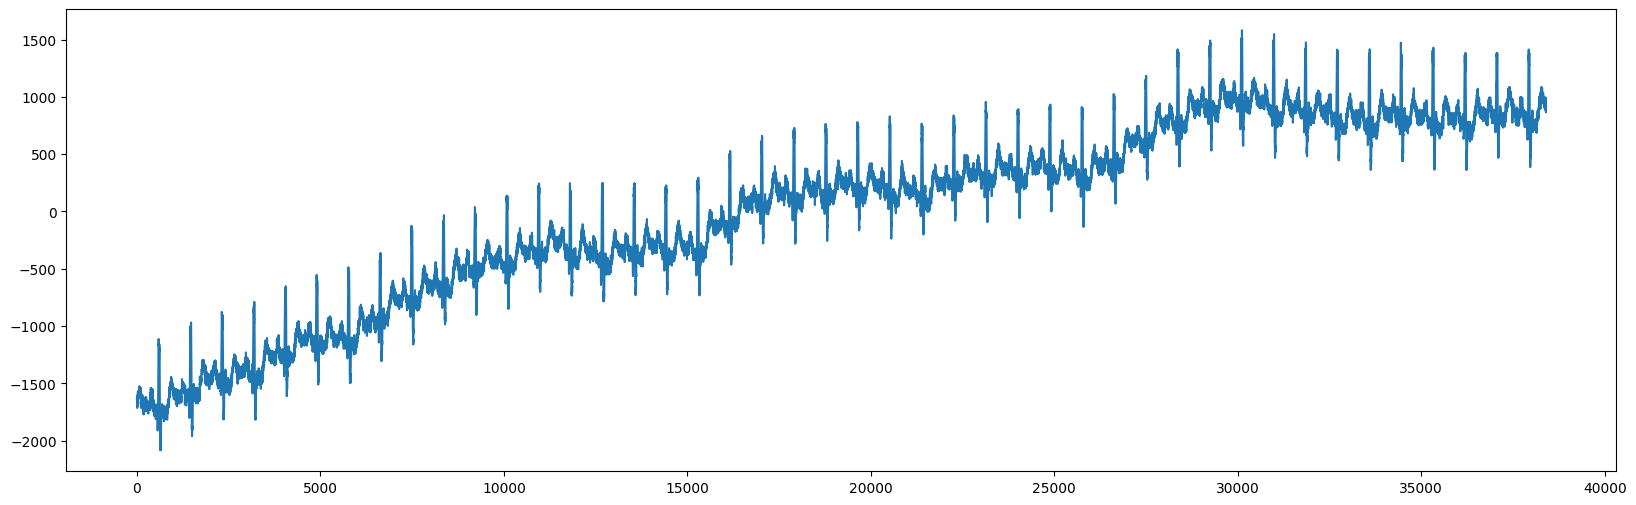

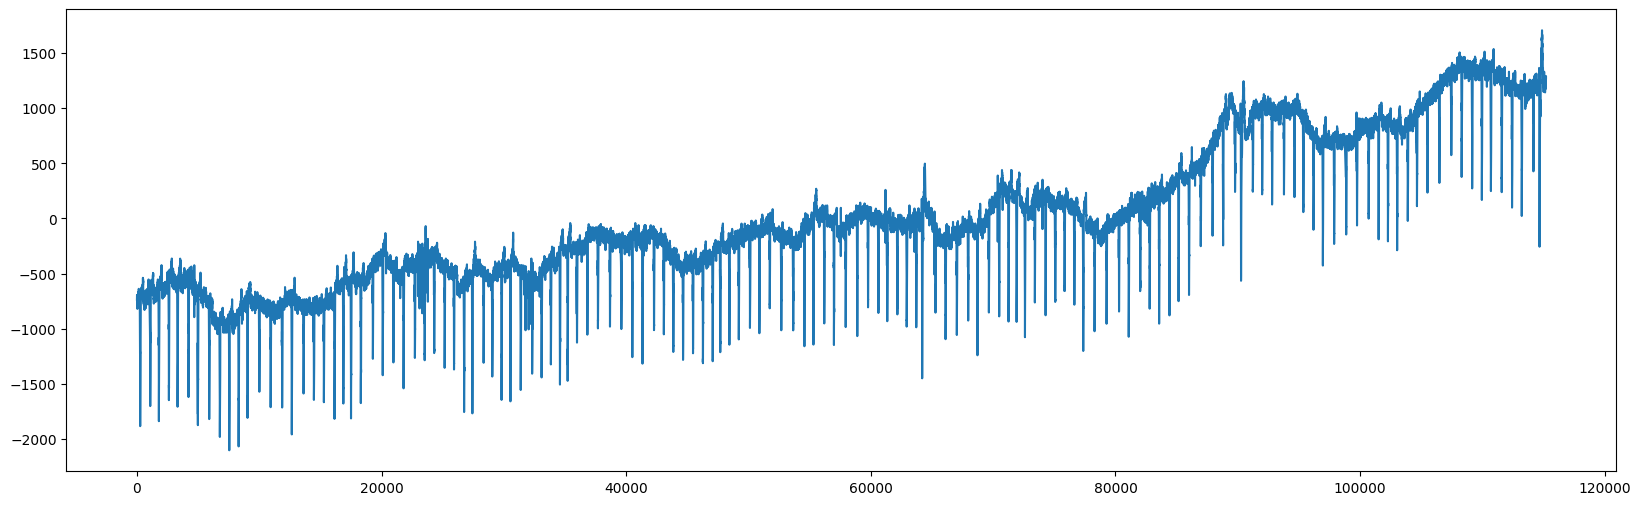

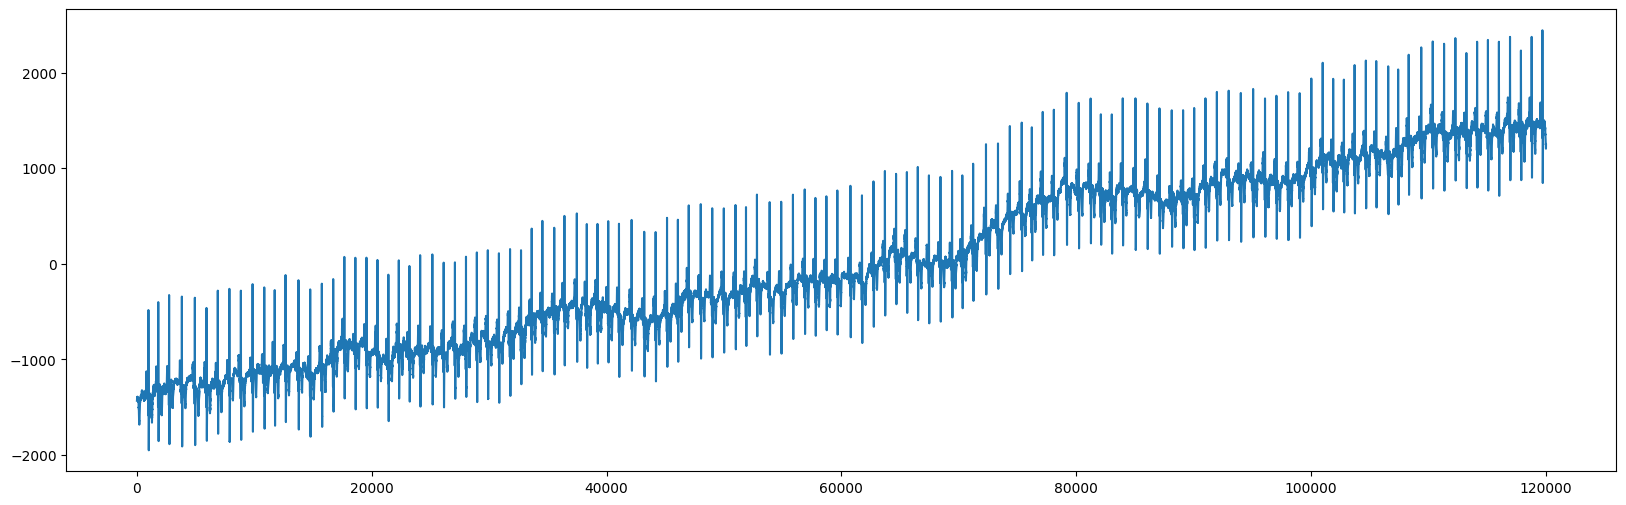

In [ ]:
if split == 'Intra':
  i=1
  print("Total number of ECGs: ",len(X_train_record)+len(X_test_record))
  mi_num = len([x for x in y_train_record if x == 1]) + len([x for x in y_test_record if x == 1])
  healthy_num = len(y_train_record)+len(y_test_record)-mi_num
  print("1. Total number of MI ECGs: ",mi_num)
  print("2. Total number of healthy ECGs: ",healthy_num,"\n")

  print("3. Number of subjects in trainset:", len(X_train_record))
  print("Total number of  MI ECGs in trainset:",len([x for x in y_train_record if x == 1]))
  print("Total number of normal ECGs in trainset:",len([x for x in y_train_record if x == 0]),"\n")
  print("4. Number of subjects in trainset:", len(X_test_record))
  print("Total number of MI ECGS in testset:",len([x for x in y_test_record if x == 1]))
  print("Total number of normal ECGs in testset:",len([x for x in y_test_record if x == 0]))

  print("Type of the X_train_record readings: ",type(X_train_record))
  print("Type of the X_train_record[i] readings: ",type(X_train_record[i]))

  print("Type of the X_test_record readings: ",type(X_test_record))
  print("Type of the X_test_record[i] readings: ",type(X_test_record[i]))

  print("Type of the y_train_record readings: ",type(y_train_record))
  print("Type of the y_train_record[i] readings: ",type(y_train_record[i]))

  print("Type of the y_test_recordreadings: ",type(y_test_record))
  print("Type of the y_test_record[i] readings: ",type(y_test_record[i]))

  for i in range(3): #Check first 3 record in trainset
    print("Sample: ",i+1)
    print("Readings from 15 leads:\n",X_train_record[i],"\n")
    print("Type of the readings: ",type(X_train_record[i]))
    print("Shape of the readings: ",X_train_record[i].shape,"\n")
    print("Numpy type of the readings: ",X_train_record[i].dtype,"\n")

    print("\nReadings from only II lead (1D):\n",X_train_record[i]) # Lead II data (1D array)
    print("Shape of the readings from only II lead (1D): ",X_train_record[i].shape,"\n")
    print("Shape of the readings from only II lead (1D): ",X_train_record[i].dtype,"\n")
    print("Readings from only II lead (2D): \n",X_train_record[i].reshape(len(X_train_record[i]),1))  # Lead II data (2D array)
    print("Shape of the readings from only II lead (2D): ",X_train_record[i].reshape(len(X_train_record[i]),1).shape,"\n")
    print("Numpy of the readings from only II lead (2D): ",X_train_record[i].dtype,"\n")

    plt.figure(figsize=(20, 6))
    plt.plot(X_train_record[i]) # Visualization of lead II data of each record
    print("-------------------------------------------------------------------------------")

    #dataframe = record_list[0].to_dataframe()
    #print(dataframe)
    #print(dataframe.describe())
    #print(dataframe['ii'].shape)
else:
  for fold in fold_data:
    fold_number = fold['fold']

    # Access trainset, valset, and testset for the current fold
    X_train_record = fold['train']['X']
    y_train_record = fold['train']['y']
    X_val_record = fold['val']['X']
    y_val_record = fold['val']['y']
    X_test_record = fold['test']['X']
    y_test_record = fold['test']['y']

    for i in range(3):
      plt.figure(figsize=(20, 6))
      plt.plot(X_train_record[i]) # Visualization of lead II data of each record
      print("-------------------------------------------------------------------------------")

    mi_num = len([x for x in y_train_record if x == 1]) + len([x for x in y_test_record if x == 1])+len([x for x in y_val_record if x == 1])
    healthy_num = len(y_train_record)+len(y_test_record)+len(y_val_record)-mi_num
    print("1. Total number of MI ECGs: ",mi_num)
    print("2. Total number of healthy ECGs: ",healthy_num,"\n")

    print(f"Fold {fold_number}:")
    print(f"Training records count: {len(X_train_record)}")
    print(f"Validation records count: {len(X_val_record)}")
    print(f"Test records count: {len(X_test_record)}")
    print("Total number of ECGs: ",len(X_train_record)+len(X_val_record)+len(X_test_record))

    # Access specific data
    print(f"First training record (example): {X_train_record[0]}")
    print(f"First training label (example): {y_train_record[0]}")
    print(f"First validation record (example): {X_val_record[0]}")
    print(f"First validation label (example): {y_val_record[0]}")
    print(f"First test record (example): {X_test_record[0]}")
    print(f"First test label (example): {y_test_record[0]}")

    break

### 4.3 Save / Read the extracted signal

In [ ]:
# if split == 'Intra':
#   mode='intra'
#   with open(f'{mode}_X_train_record.pkl', 'wb') as f:
#     pickle.dump(X_train_record, f)

#   with open(f'{mode}_X_test_record.pkl', 'wb') as f:
#     pickle.dump(X_test_record, f)

#   with open(f'{mode}_y_train_record.pkl', 'wb') as f:
#     pickle.dump(y_train_record, f)

#   with open(f'{mode}_y_test_record.pkl', 'wb') as f:
#     pickle.dump(y_test_record, f)
# else:
#   mode='inter'
#   with open(f'{skf.n_splits}fold_{mode}_data.pkl', 'wb') as f:
#     pickle.dump(fold_data, f)

In [ ]:
# if split == 'Intra':

#   mode='intra'
#   with open(f'{mode}_X_train_record.pkl', 'rb') as f:
#     X_train_record = pickle.load(f)

#   with open(f'{mode}_X_test_record.pkl', 'rb') as f:
#     X_test_record = pickle.load(f)

#   with open(f'{mode}_y_train_record.pkl', 'rb') as f:
#     y_train_record = pickle.load(f)

#   with open(f'{mode}_y_test_record.pkl', 'rb') as f:
#     y_test_record = pickle.load(f)

# else:
#   mode='inter'
#   with open(f'{skf.n_splits}fold_{mode}_data.pkl', 'rb') as f:
#     fold_data = pickle.load(f)

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
1. Total number of MI ECGs:  368
2. Total number of healthy ECGs:  324 

Fold 1:
Training records count: 568
Validation records count: 30
Test records count: 94
Total number of ECGs:  692
First training record (example): [-1642 -1633 -1645 ...   865   896   918]
First training label (example): 1
First validation record (example): [-4915 -4914 -4916 ...  -913  -912  -924]
First validation label (example): 1
First test record (example): [-1481 -1477 -1475 ...   875   873   874]
First test label (example): 0
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
1. Total 

<ipython-input-10-41eee461768e>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 6))



1. Total number of MI ECGs:  368
2. Total number of healthy ECGs:  304 

Fold 8:
Training records count: 535
Validation records count: 43
Test records count: 94
Total number of ECGs:  672
First training record (example): [-1642 -1633 -1645 ...   865   896   918]
First training label (example): 1
First validation record (example): [-736 -702 -705 ... 1264 1275 1281]
First validation label (example): 1
First test record (example): [-1481 -1477 -1475 ...   875   873   874]
First test label (example): 0
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
1. Total number of MI ECGs:  368
2. Total number of healthy ECGs:  316 

Fold 9:
Training records count: 560
Validation records count: 30
Test records count: 94
Total number of ECGs:  684
First training record (example): [-1642 -1633 -1645 ...   865   89

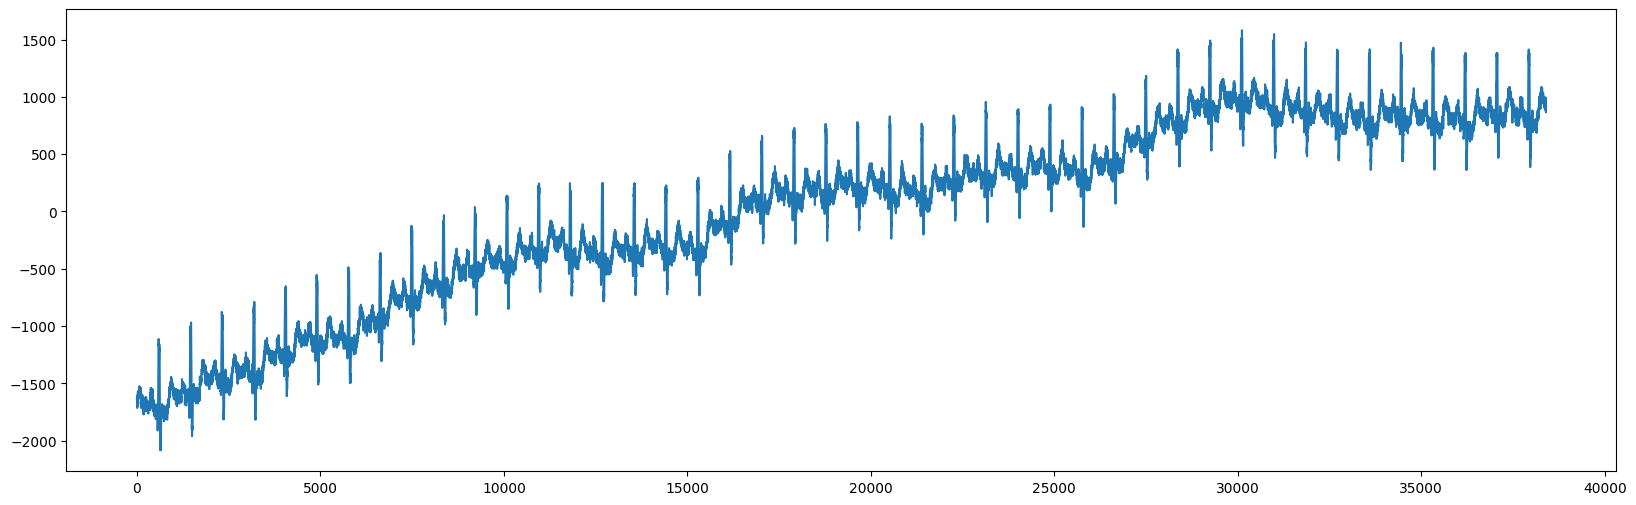

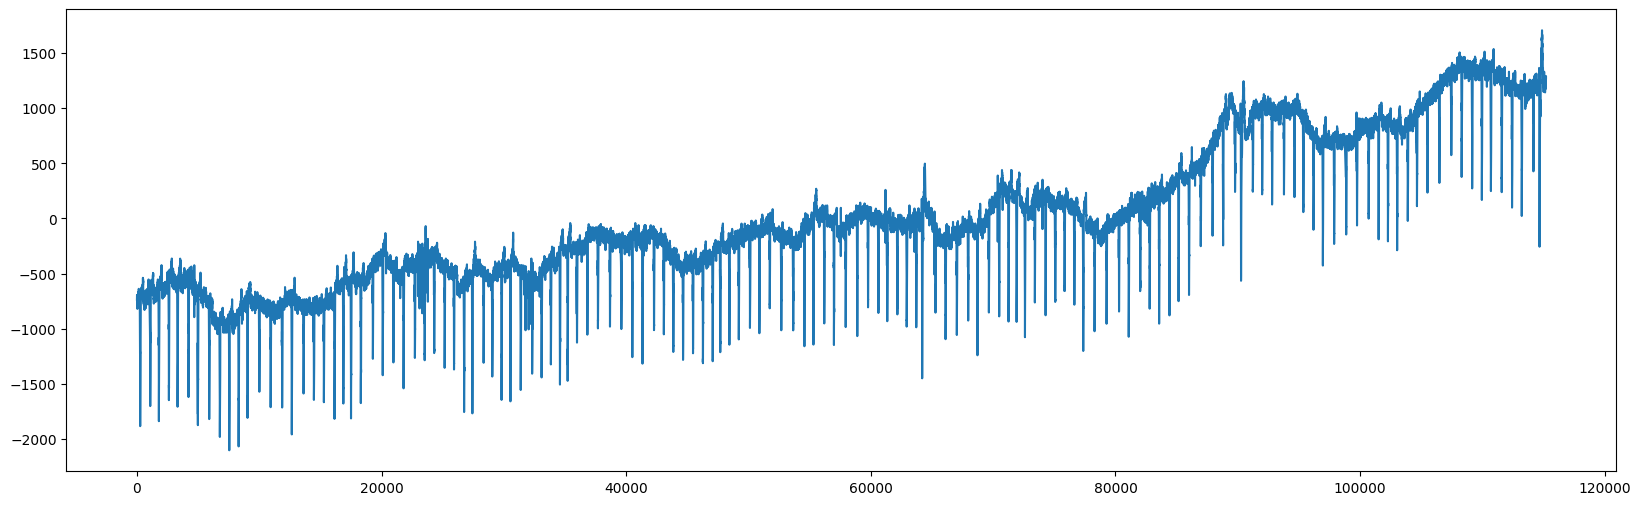

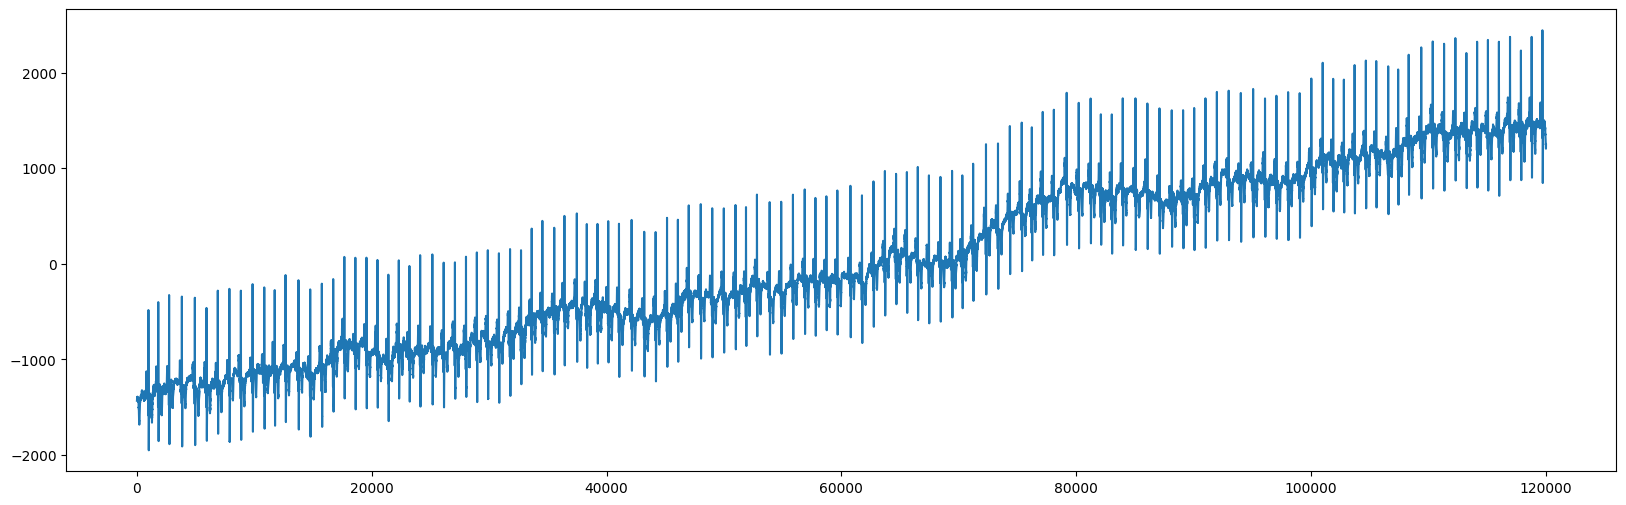

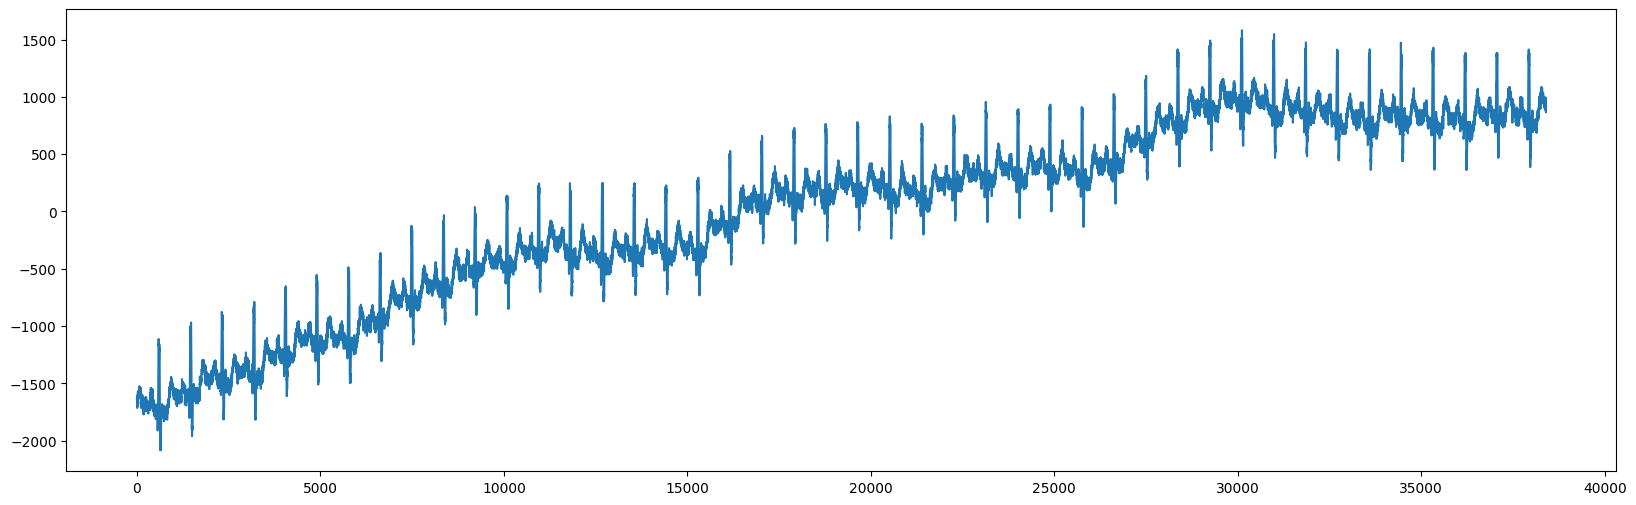

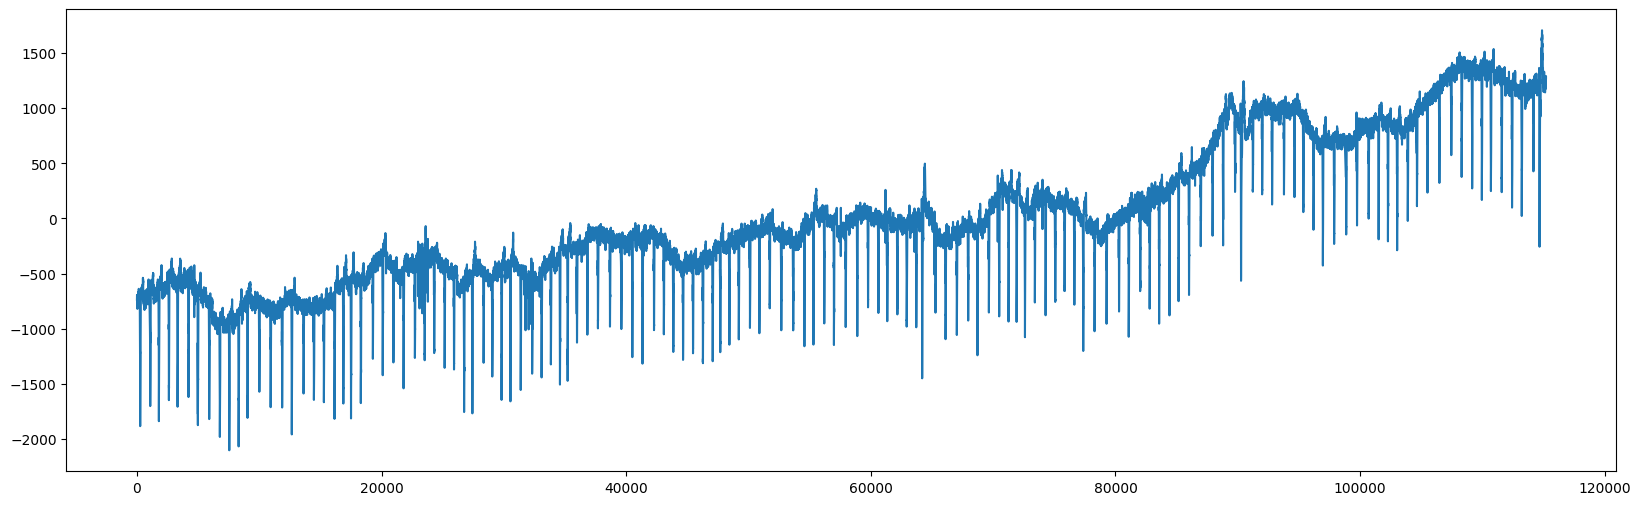

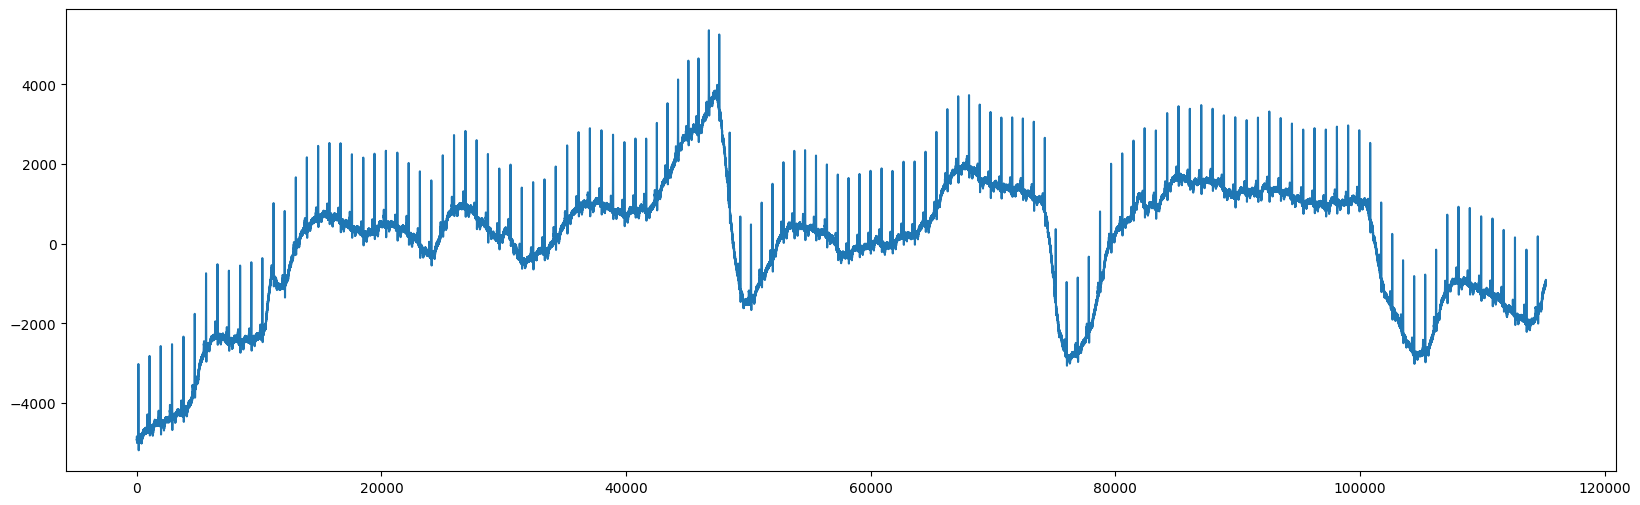

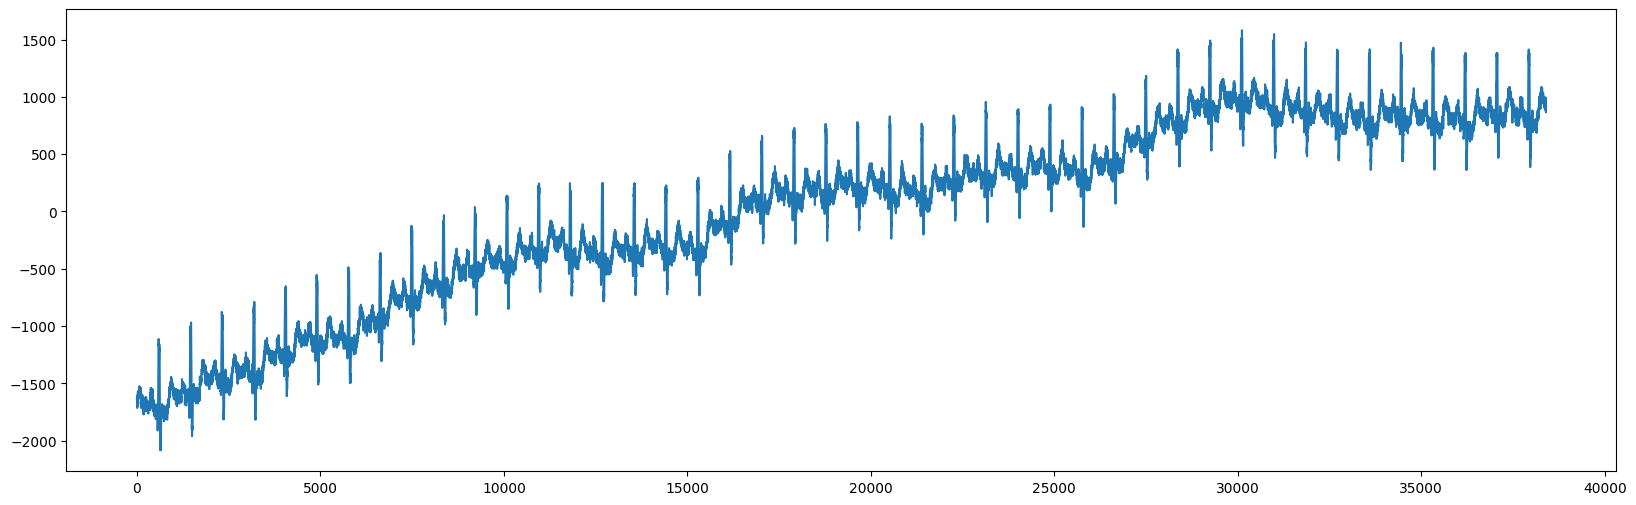

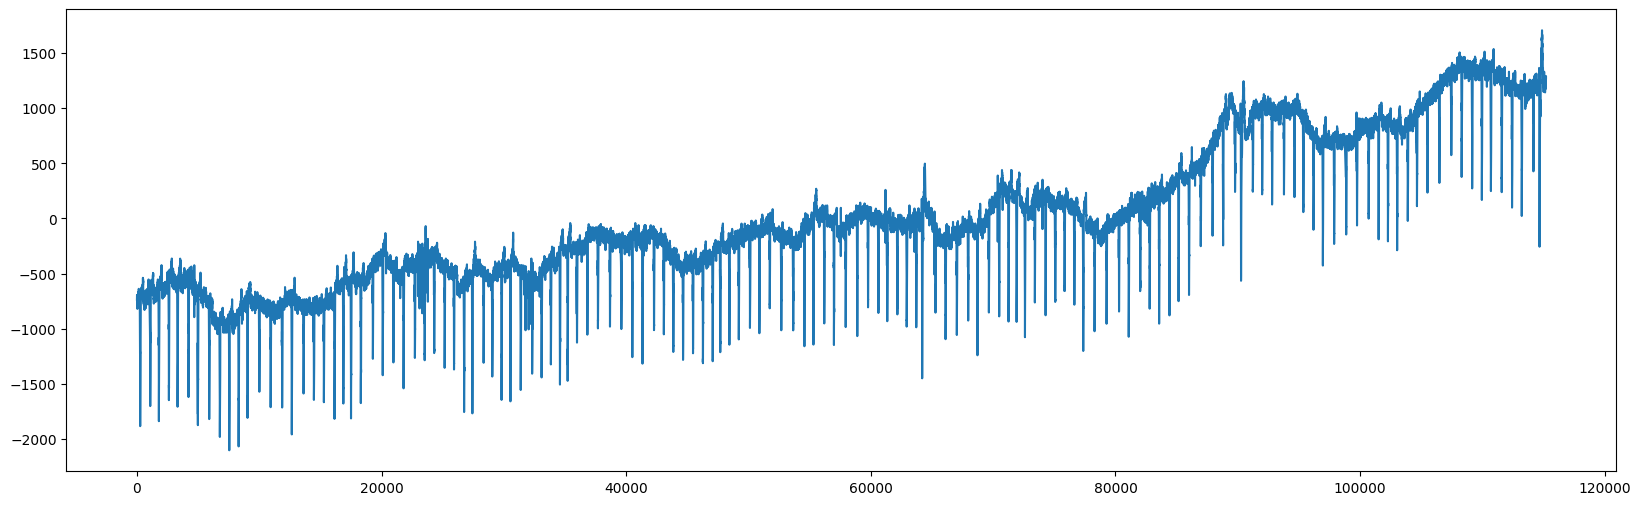

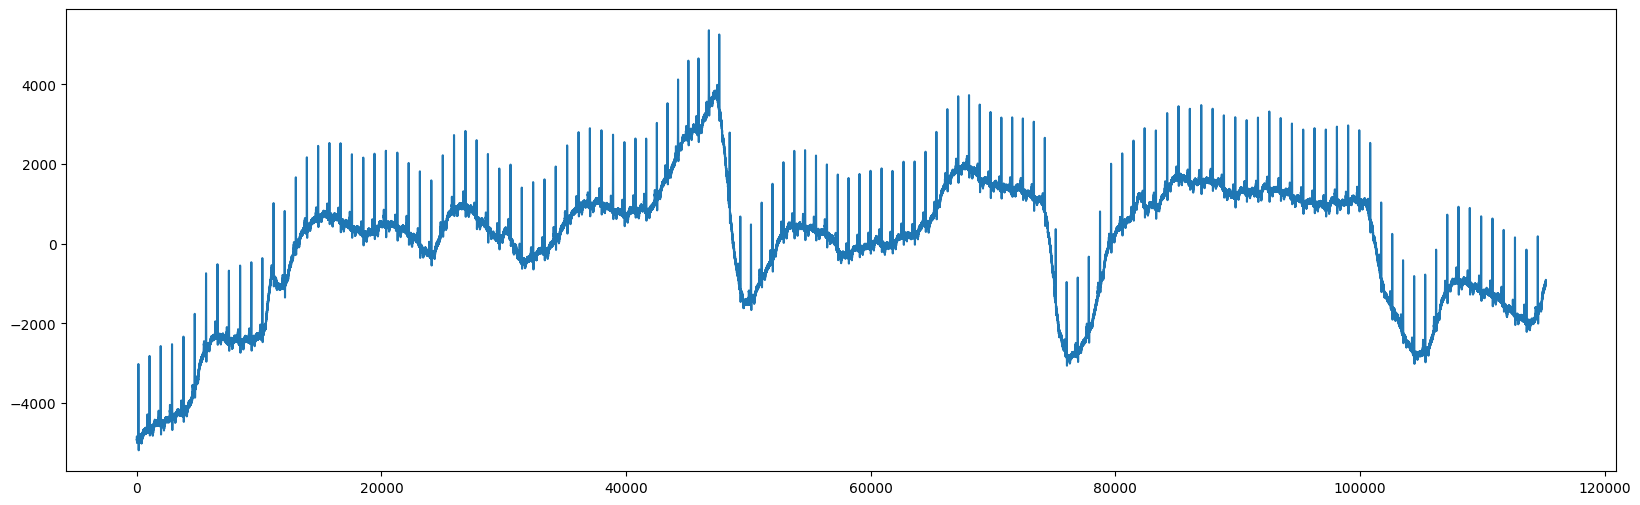

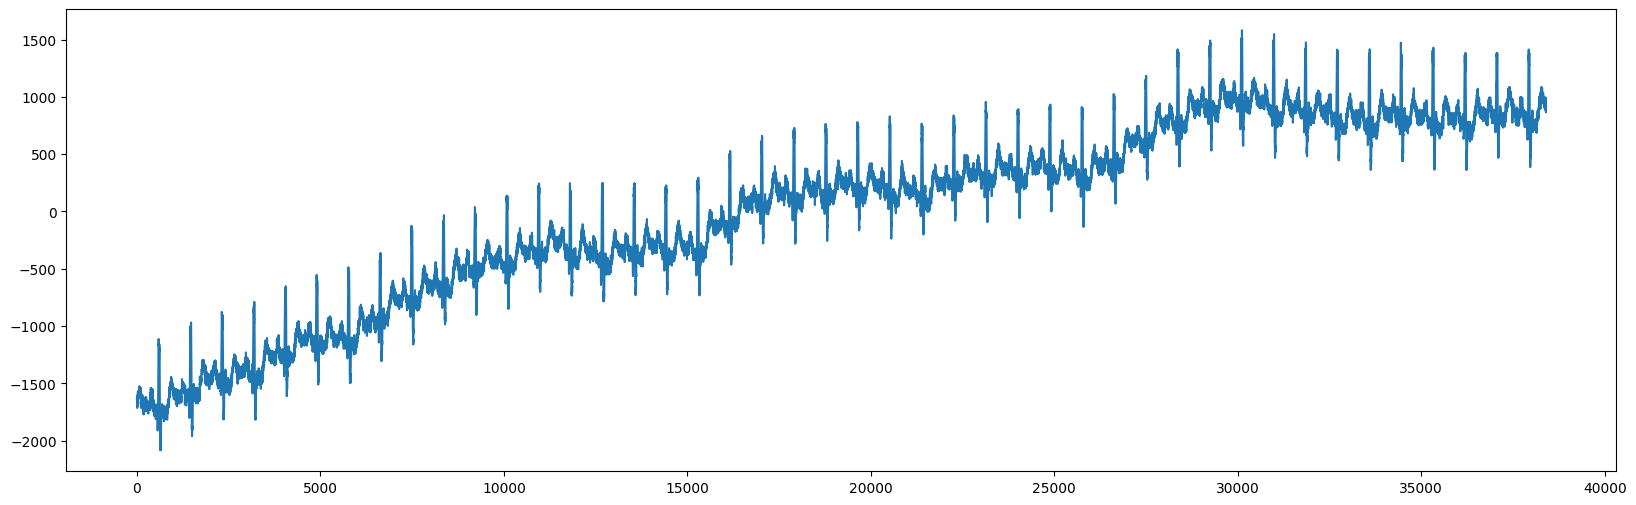

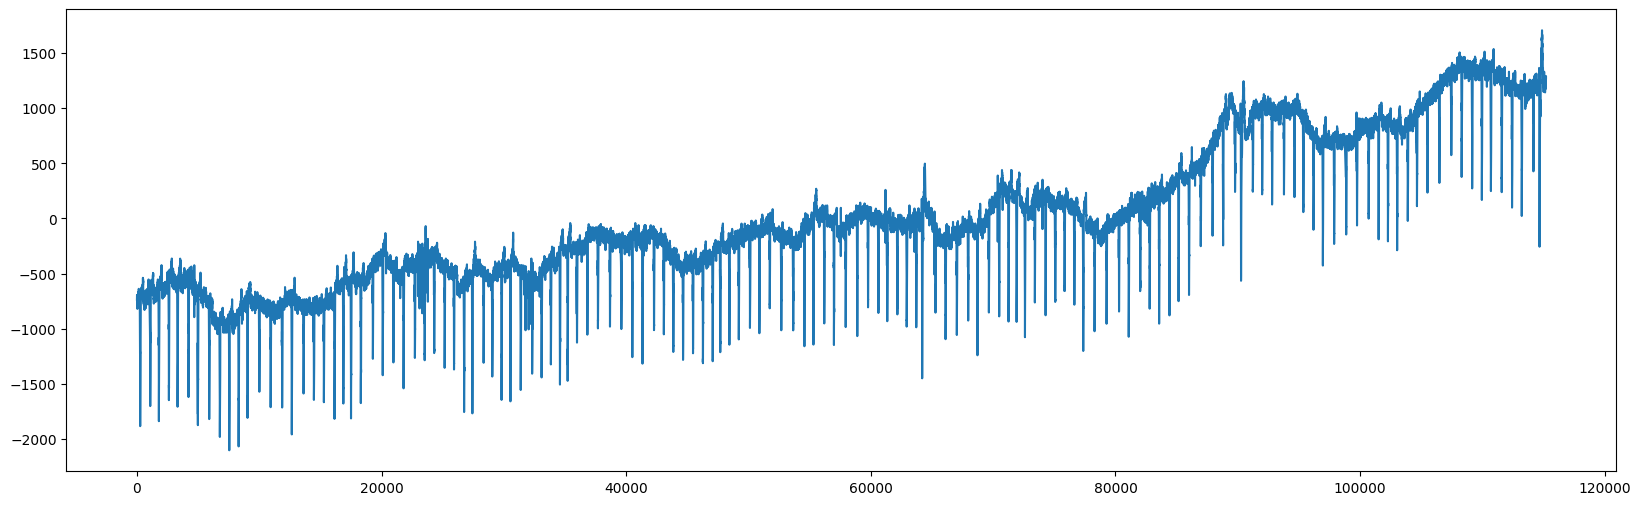

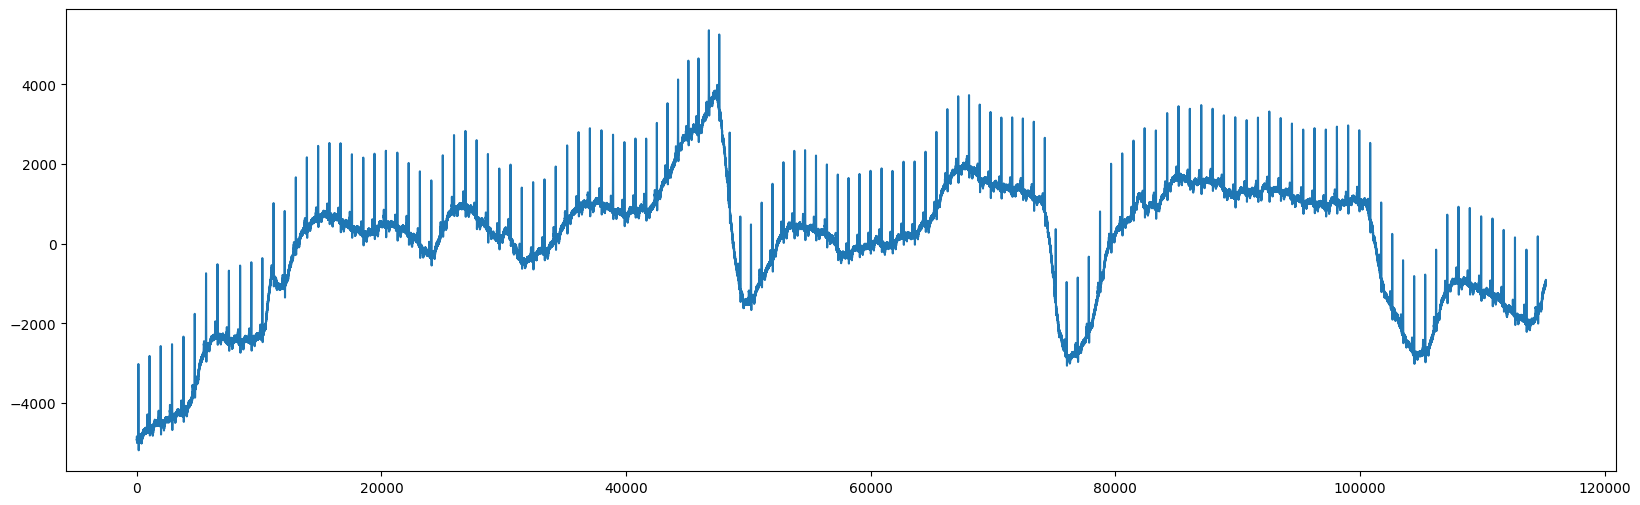

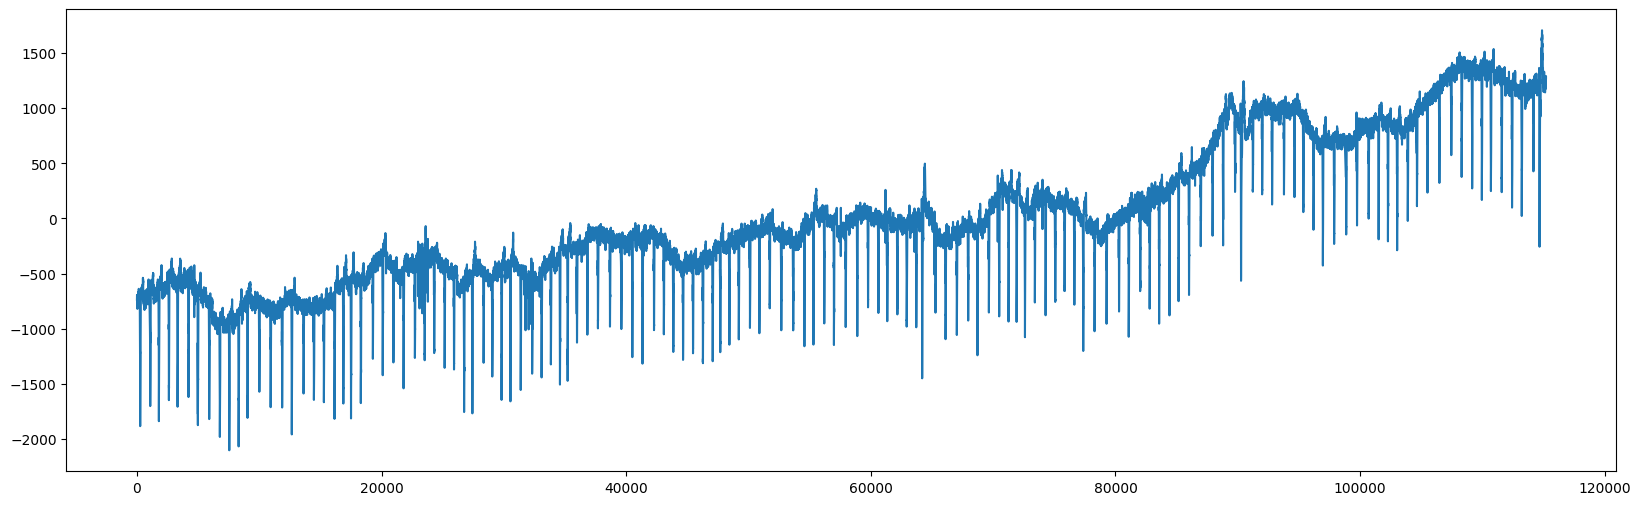

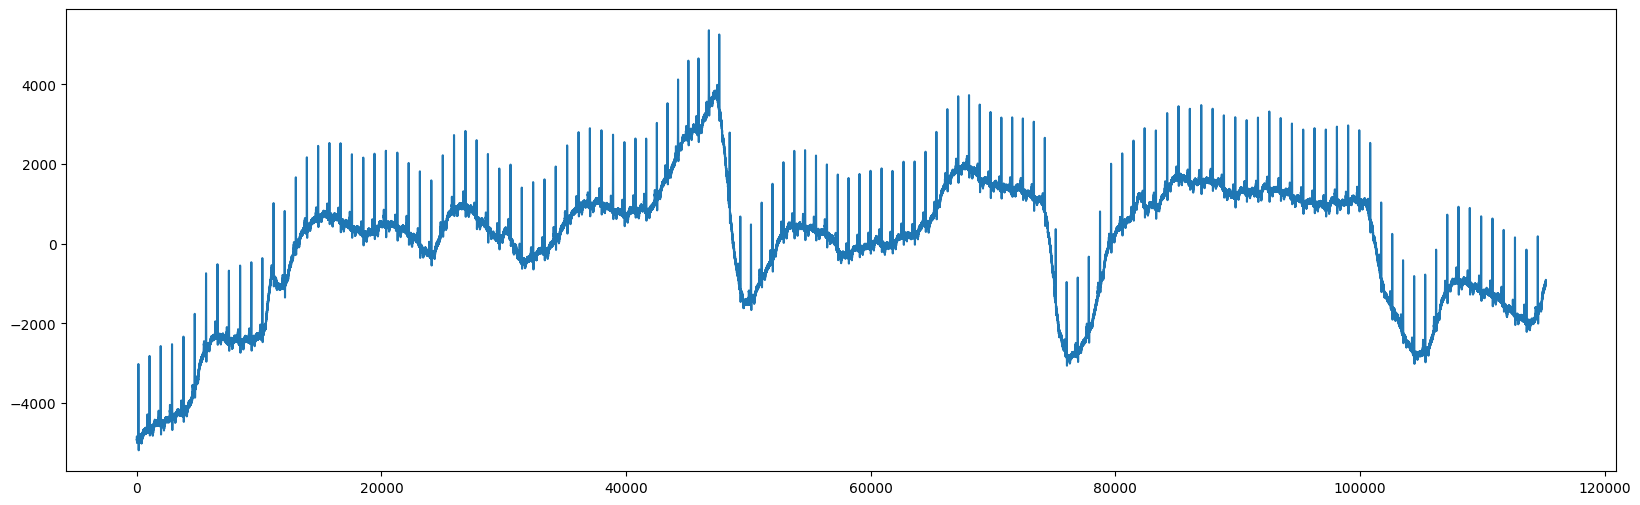

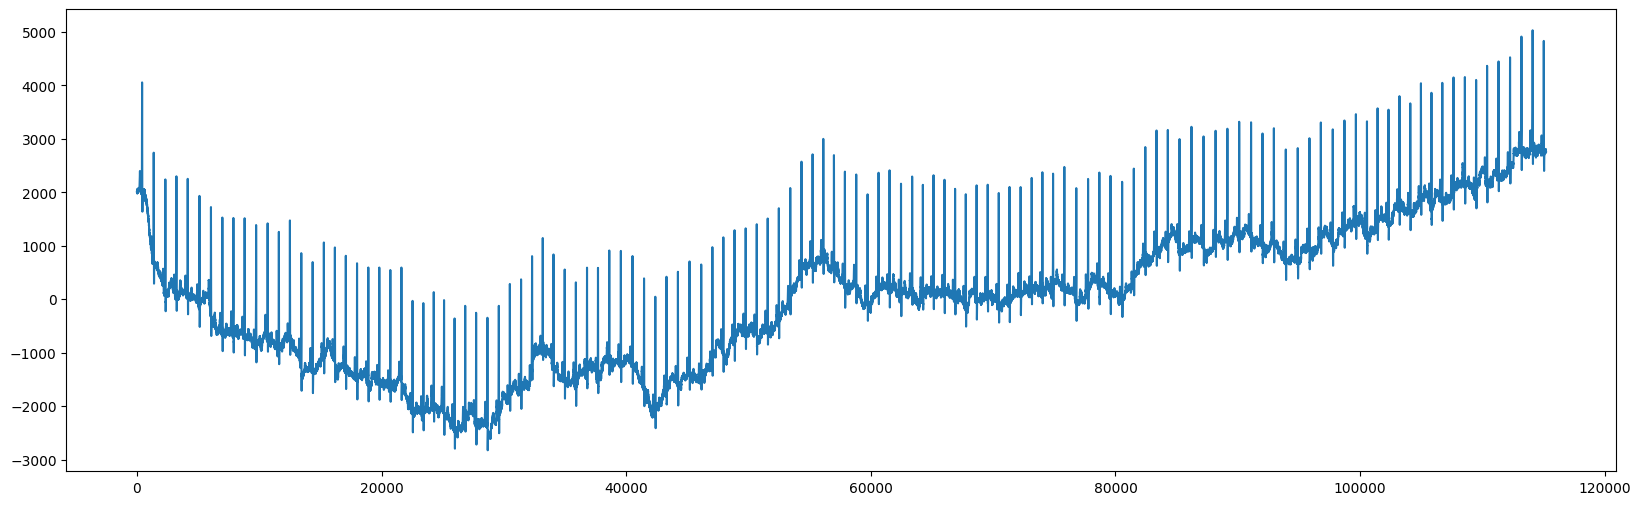

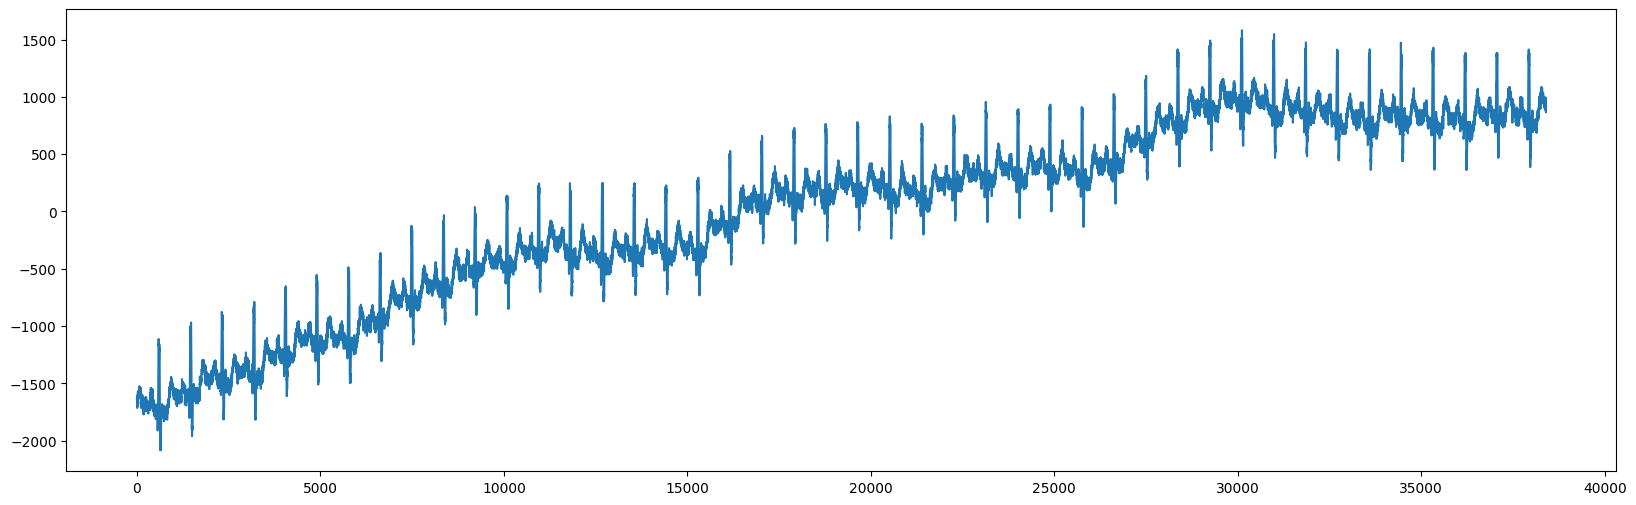

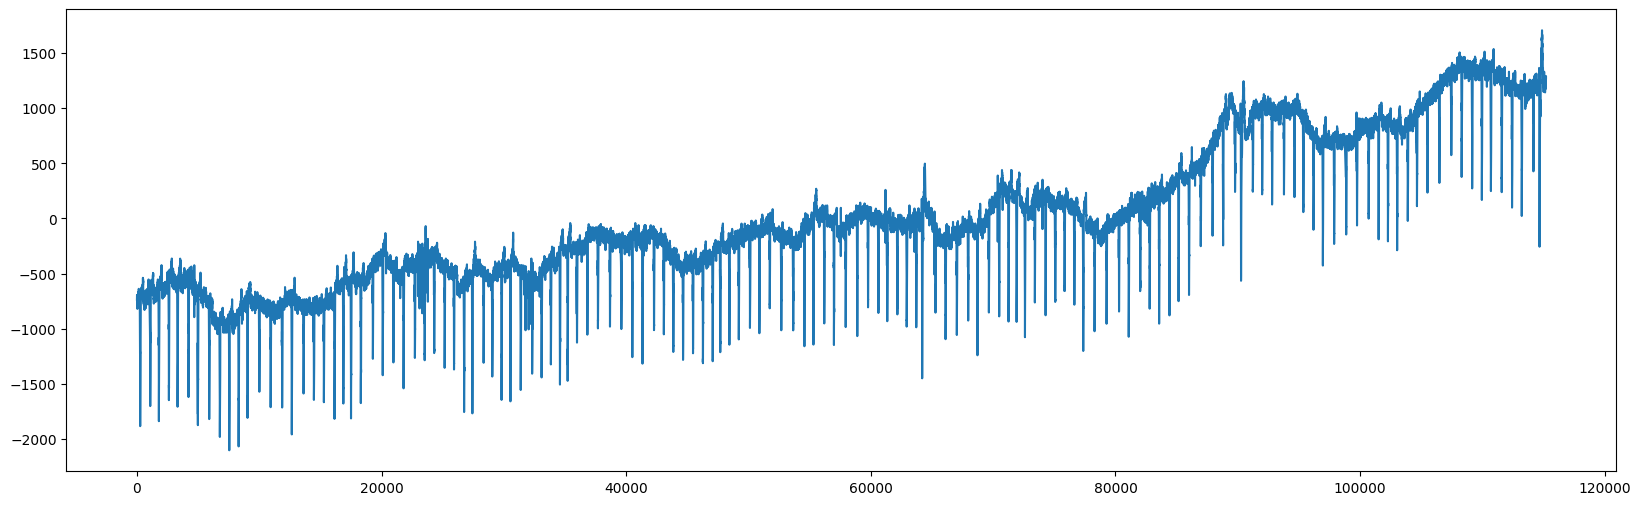

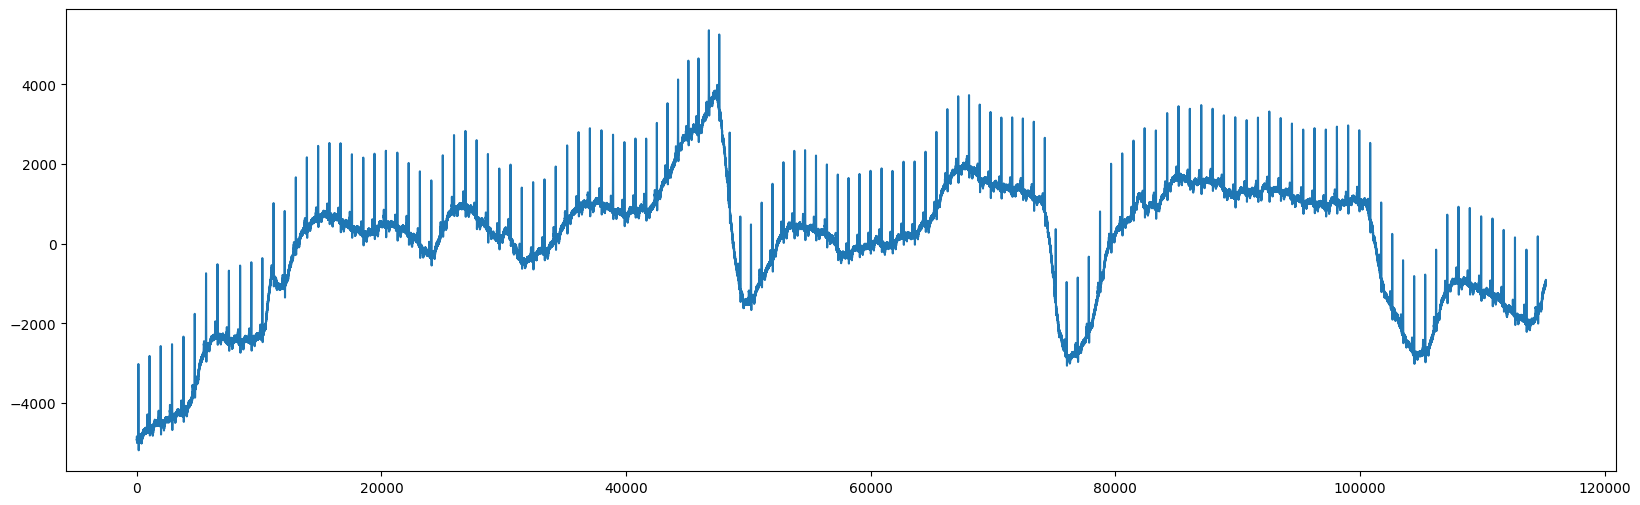

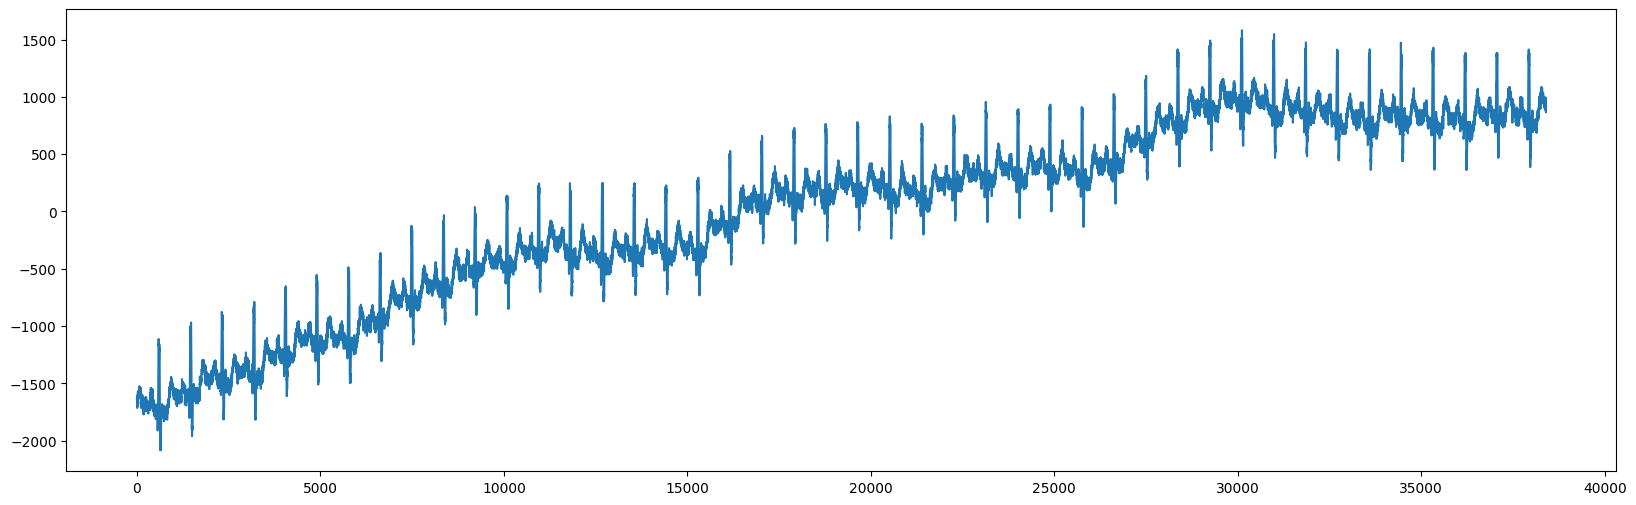

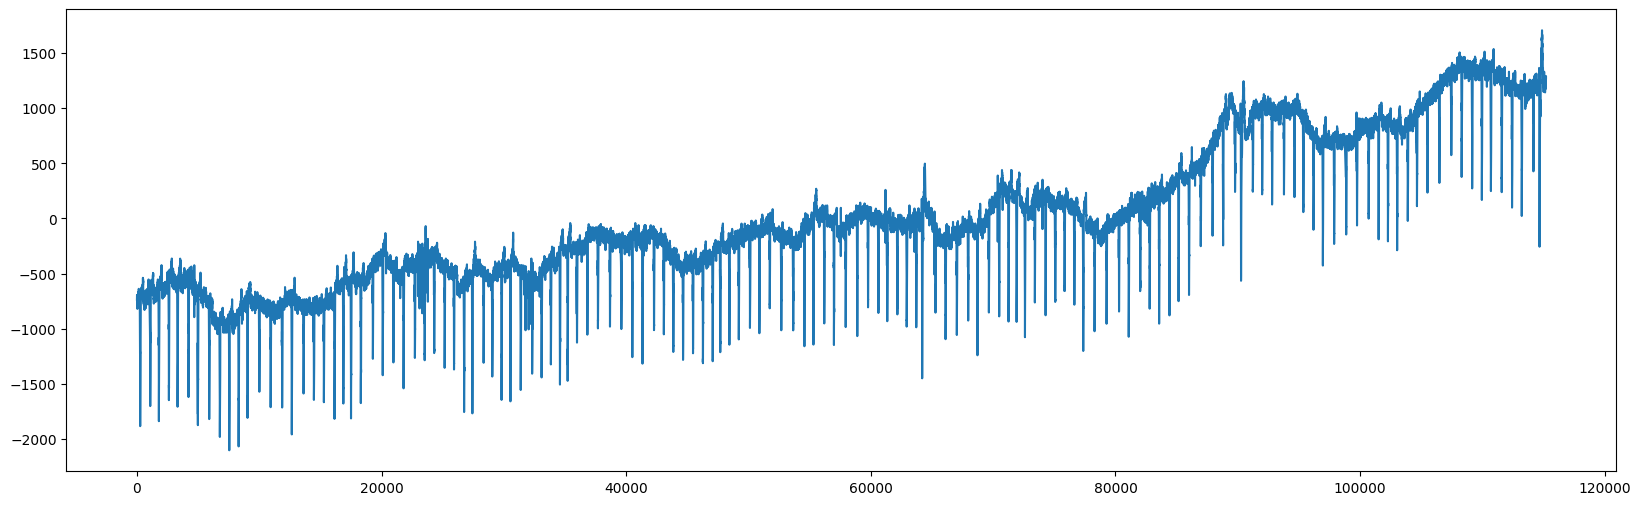

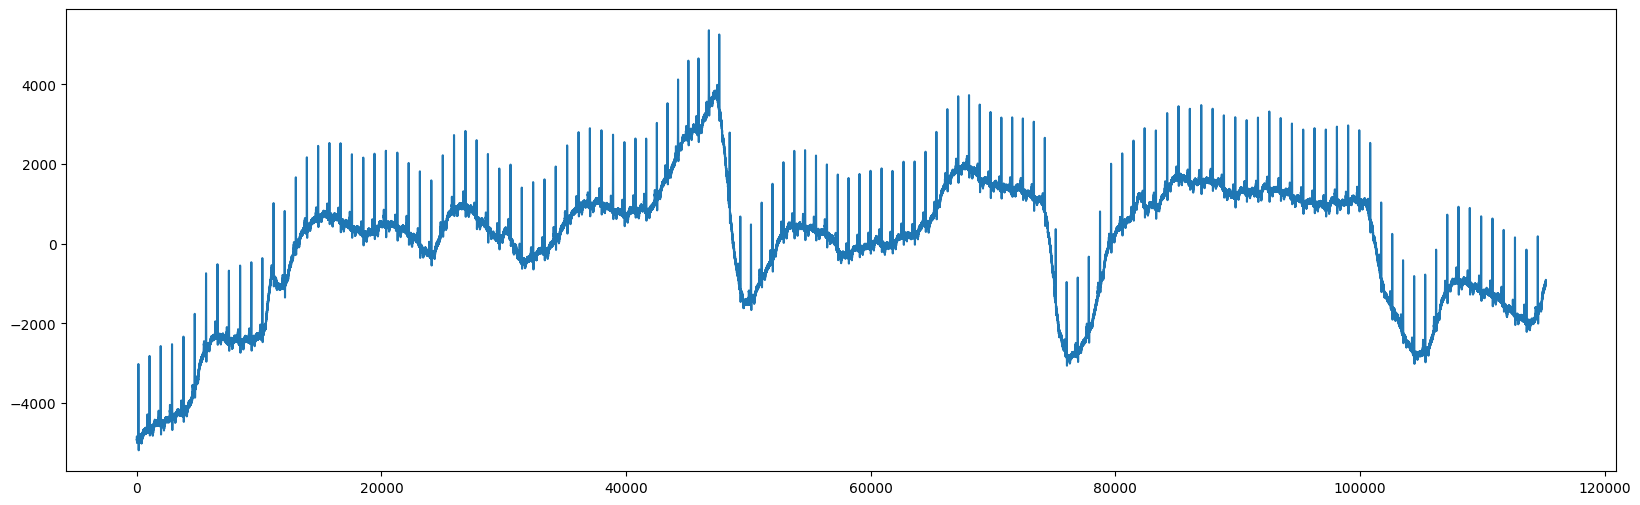

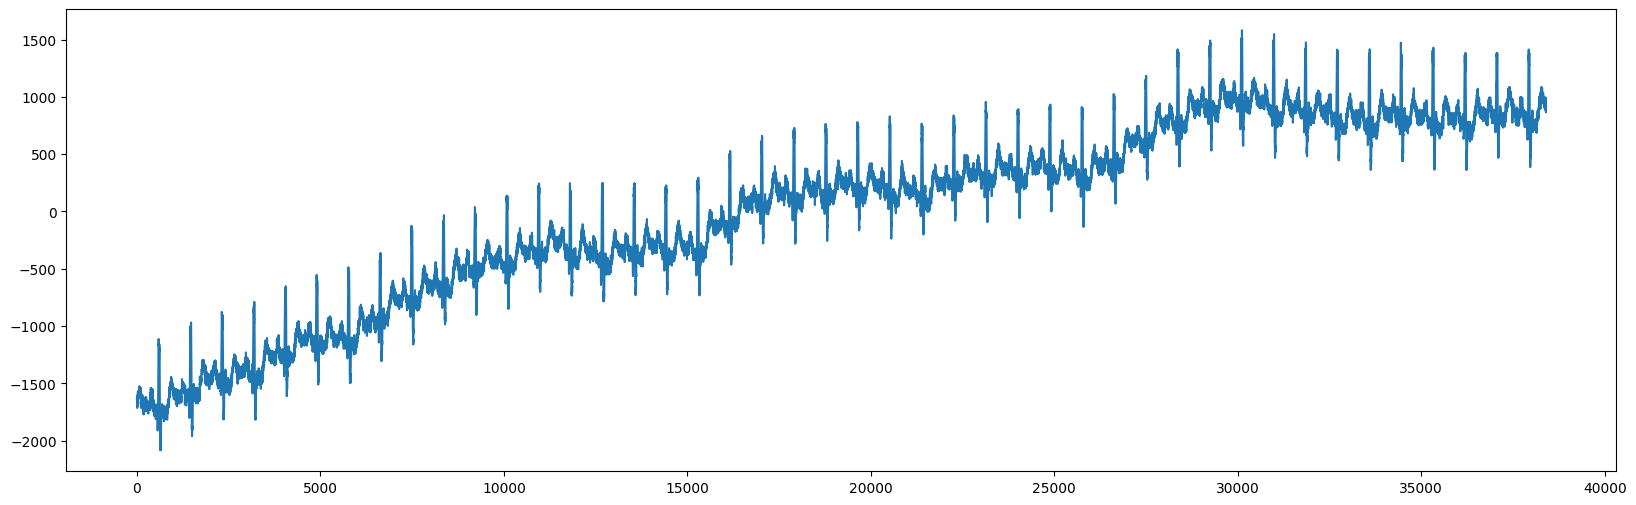

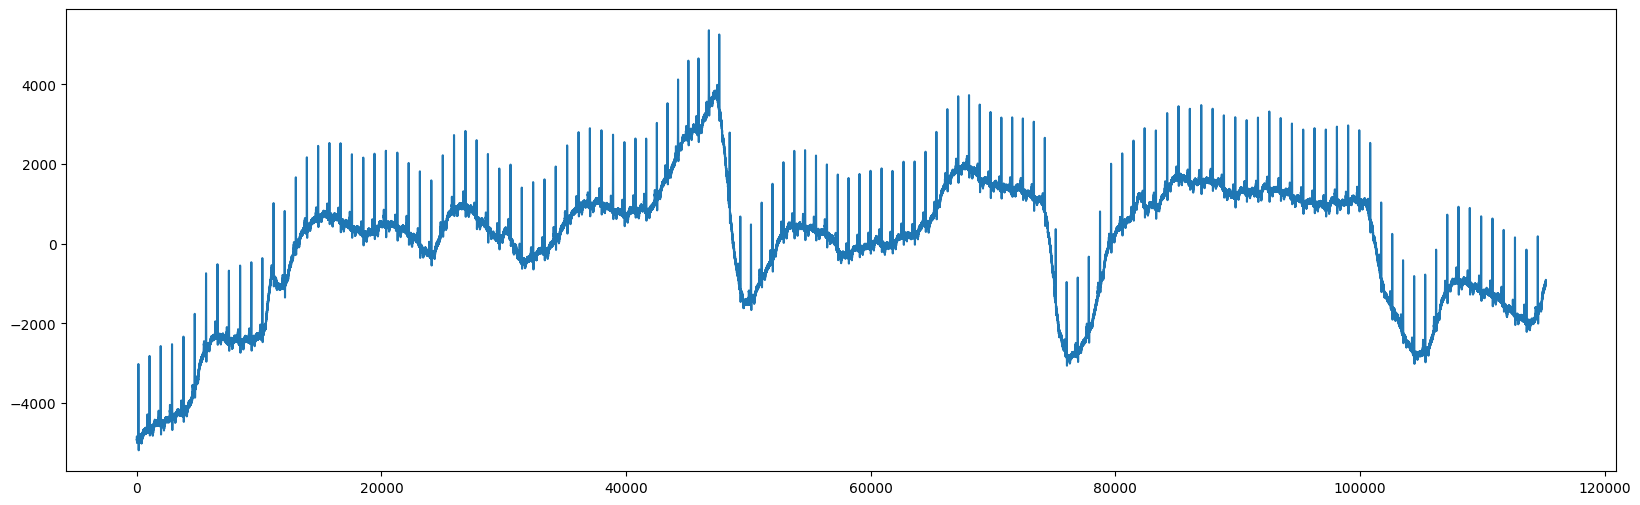

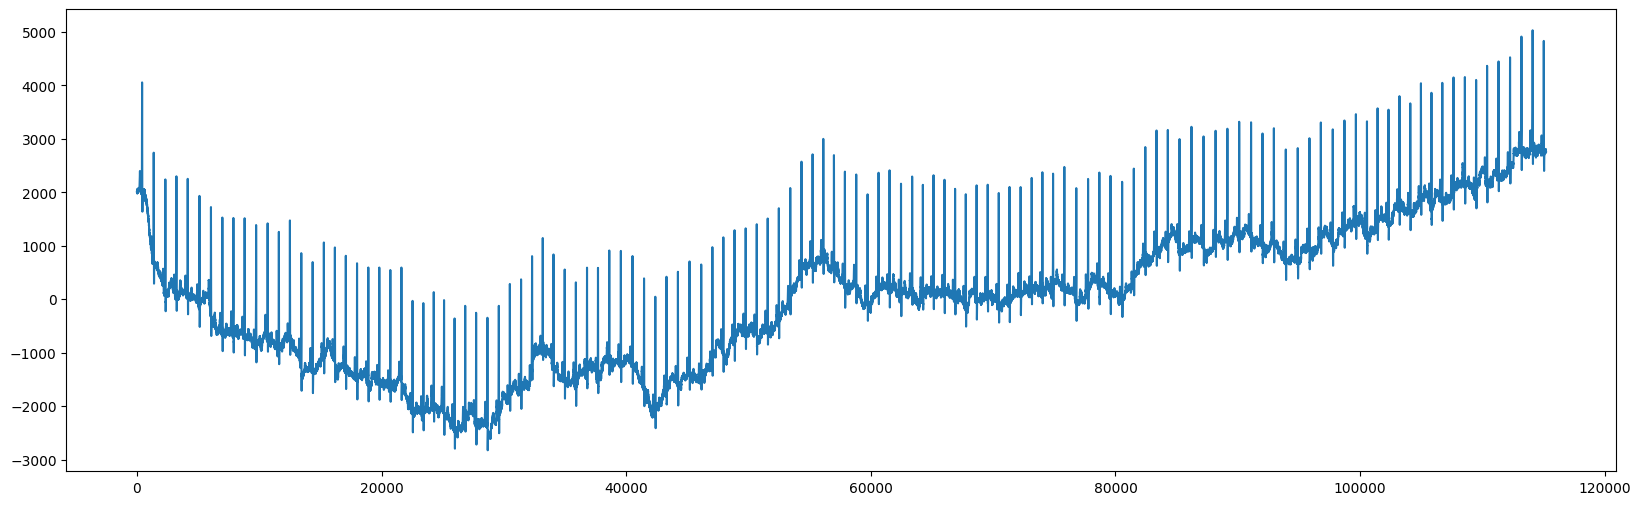

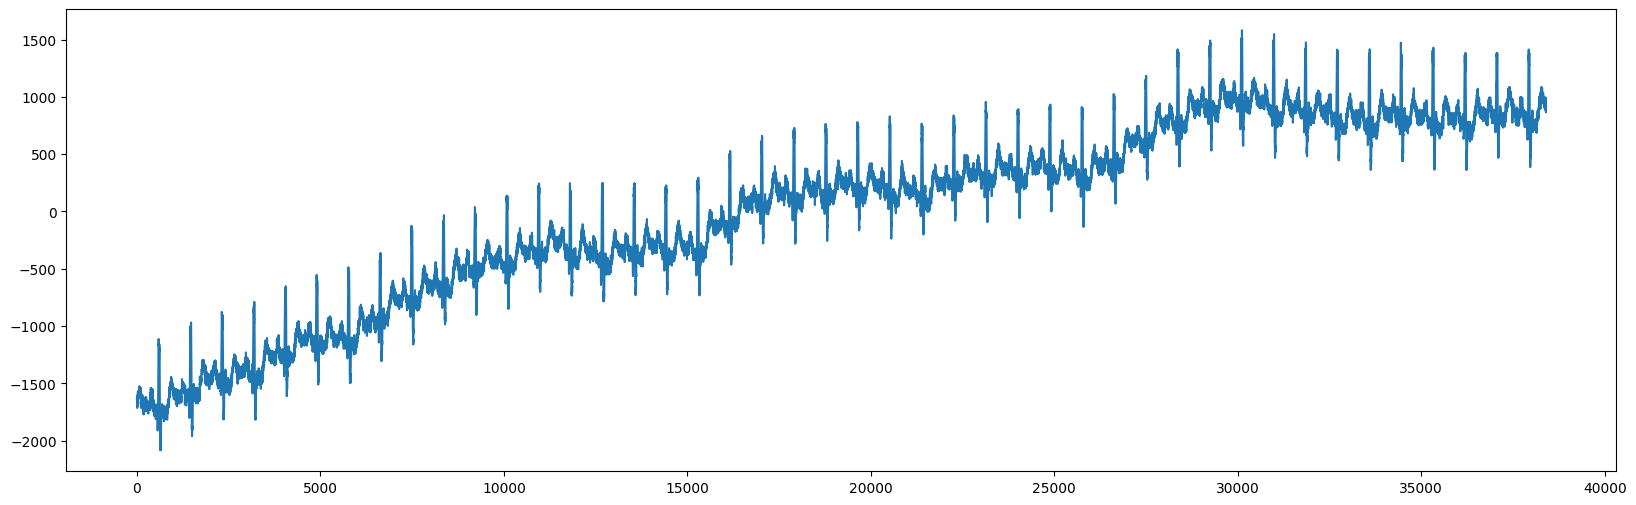

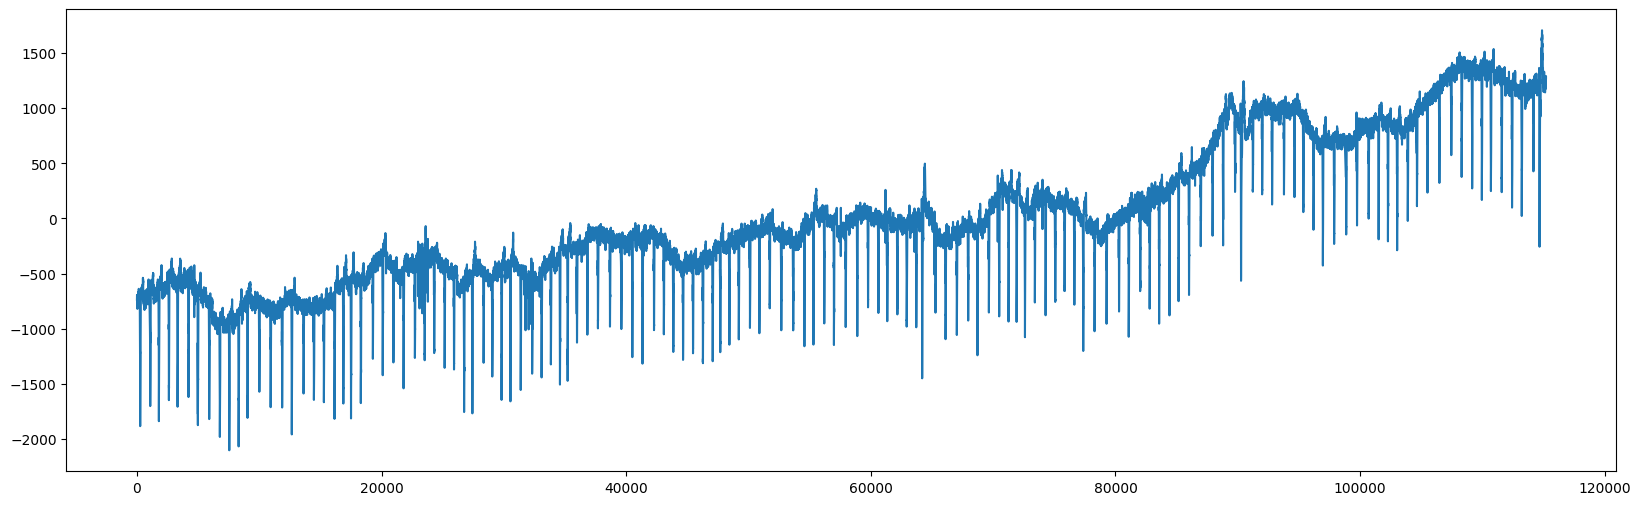

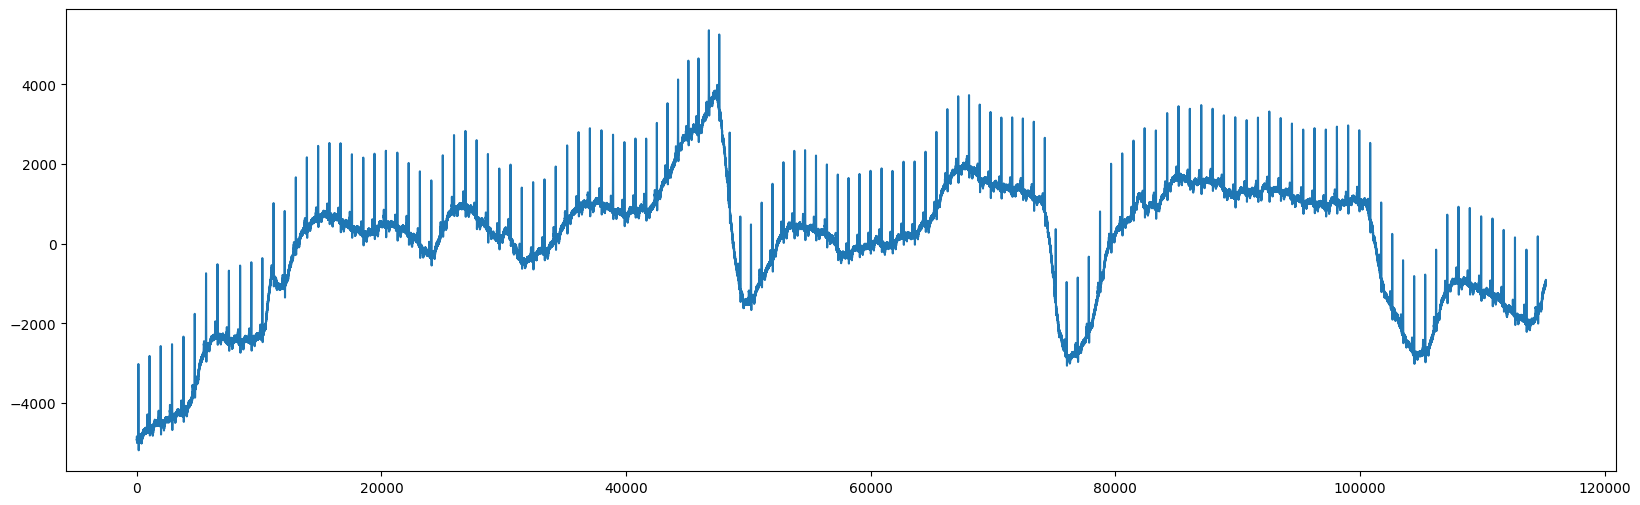

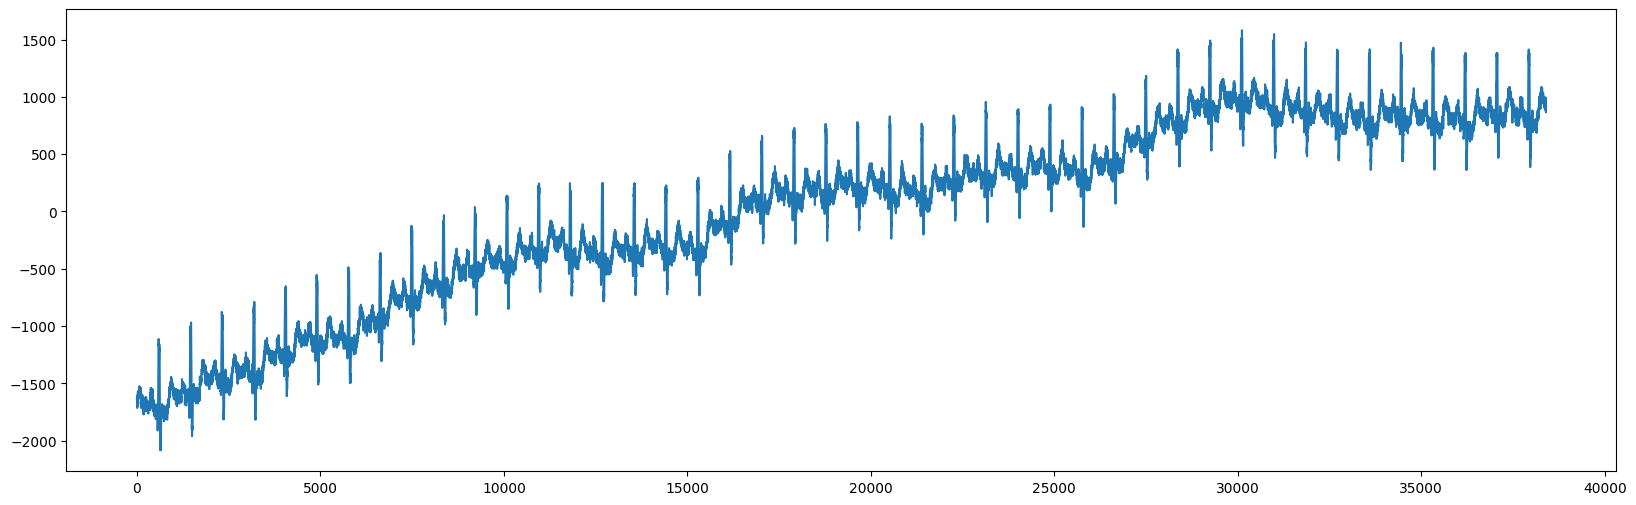

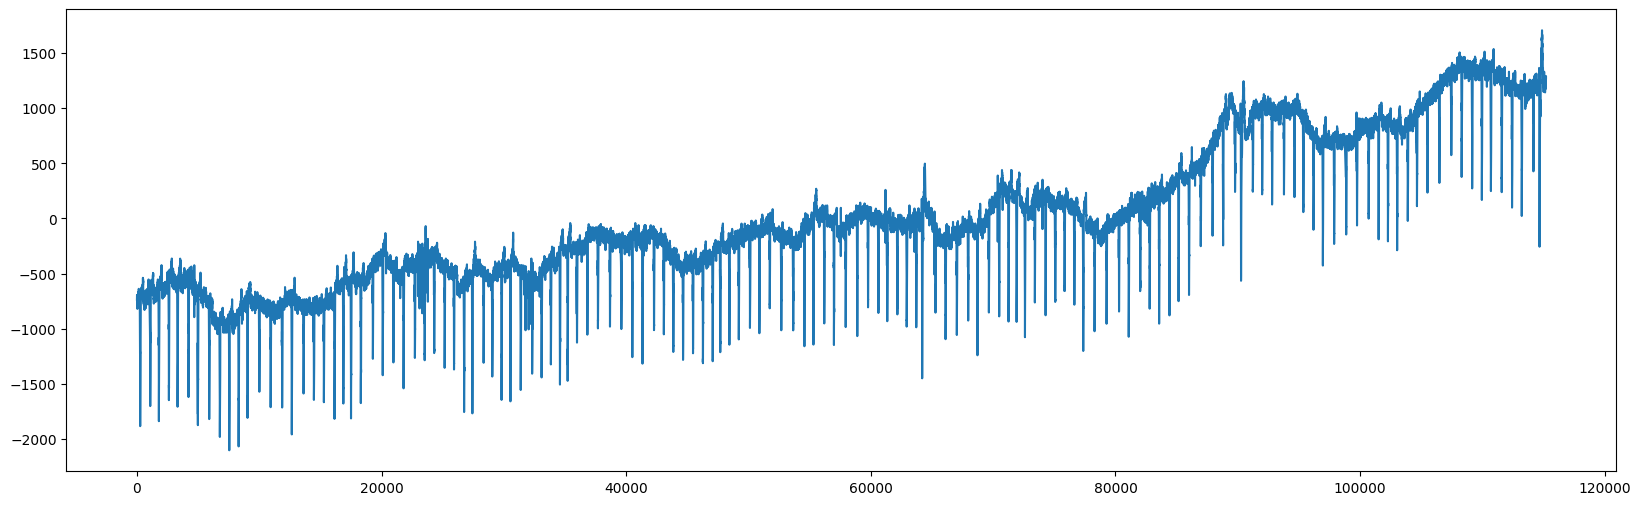

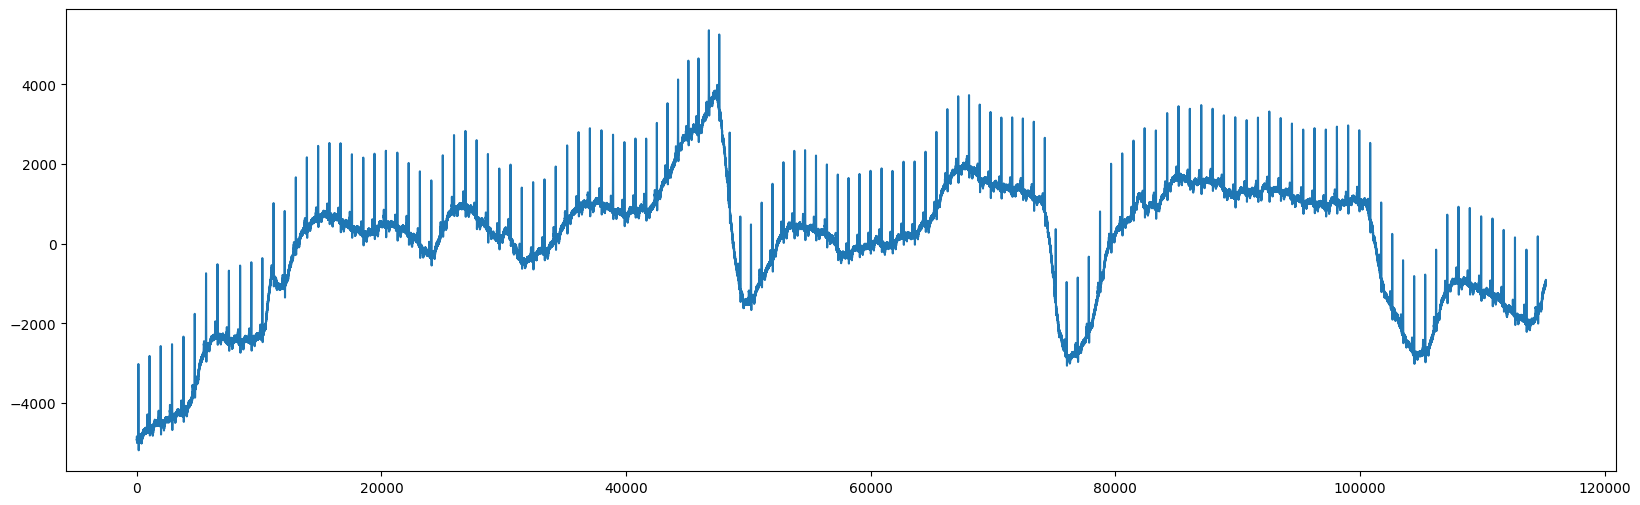

In [ ]:
if split == 'Intra':
  i=1
  print("Total number of ECGs: ",len(X_train_record)+len(X_test_record))
  mi_num = len([x for x in y_train_record if x == 1]) + len([x for x in y_test_record if x == 1])
  healthy_num = len(y_train_record)+len(y_test_record)-mi_num
  print("1. Total number of MI ECGs: ",mi_num)
  print("2. Total number of healthy ECGs: ",healthy_num,"\n")

  print("3. Number of subjects in trainset:", len(X_train_record))
  print("Total number of  MI ECGs in trainset:",len([x for x in y_train_record if x == 1]))
  print("Total number of normal ECGs in trainset:",len([x for x in y_train_record if x == 0]),"\n")
  print("4. Number of subjects in trainset:", len(X_test_record))
  print("Total number of MI ECGS in testset:",len([x for x in y_test_record if x == 1]))
  print("Total number of normal ECGs in testset:",len([x for x in y_test_record if x == 0]))

  print("Type of the X_train_record readings: ",type(X_train_record))
  print("Type of the X_train_record[i] readings: ",type(X_train_record[i]))

  print("Type of the X_test_record readings: ",type(X_test_record))
  print("Type of the X_test_record[i] readings: ",type(X_test_record[i]))

  print("Type of the y_train_record readings: ",type(y_train_record))
  print("Type of the y_train_record[i] readings: ",type(y_train_record[i]))

  print("Type of the y_test_recordreadings: ",type(y_test_record))
  print("Type of the y_test_record[i] readings: ",type(y_test_record[i]))

  for i in range(3): #Check first 3 record in trainset
    print("Sample: ",i+1)
    print("Readings from 15 leads:\n",X_train_record[i],"\n")
    print("Type of the readings: ",type(X_train_record[i]))
    print("Shape of the readings: ",X_train_record[i].shape,"\n")
    print("Numpy type of the readings: ",X_train_record[i].dtype,"\n")

    print("\nReadings from only II lead (1D):\n",X_train_record[i]) # Lead II data (1D array)
    print("Shape of the readings from only II lead (1D): ",X_train_record[i].shape,"\n")
    print("Shape of the readings from only II lead (1D): ",X_train_record[i].dtype,"\n")
    print("Readings from only II lead (2D): \n",X_train_record[i].reshape(len(X_train_record[i]),1))  # Lead II data (2D array)
    print("Shape of the readings from only II lead (2D): ",X_train_record[i].reshape(len(X_train_record[i]),1).shape,"\n")
    print("Numpy of the readings from only II lead (2D): ",X_train_record[i].dtype,"\n")

    plt.figure(figsize=(20, 6))
    plt.plot(X_train_record[i]) # Visualization of lead II data of each record
    print("-------------------------------------------------------------------------------")

    #dataframe = record_list[0].to_dataframe()
    #print(dataframe)
    #print(dataframe.describe())
    #print(dataframe['ii'].shape)
else:
  for fold in fold_data:
    fold_number = fold['fold']

    # Access trainset, valset, and testset for the current fold
    X_train_record = fold['train']['X']
    y_train_record = fold['train']['y']
    X_val_record = fold['val']['X']
    y_val_record = fold['val']['y']
    X_test_record = fold['test']['X']
    y_test_record = fold['test']['y']

    for i in range(3):
      plt.figure(figsize=(20, 6))
      plt.plot(X_train_record[i]) # Visualization of lead II data of each record
      print("-------------------------------------------------------------------------------")

    mi_num = len([x for x in y_train_record if x == 1]) + len([x for x in y_test_record if x == 1])+len([x for x in y_val_record if x == 1])
    healthy_num = len(y_train_record)+len(y_test_record)+len(y_val_record)-mi_num
    print("1. Total number of MI ECGs: ",mi_num)
    print("2. Total number of healthy ECGs: ",healthy_num,"\n")

    print(f"Fold {fold_number}:")
    print(f"Training records count: {len(X_train_record)}")
    print(f"Validation records count: {len(X_val_record)}")
    print(f"Test records count: {len(X_test_record)}")
    print("Total number of ECGs: ",len(X_train_record)+len(X_val_record)+len(X_test_record))

    # Access specific data
    print(f"First training record (example): {X_train_record[0]}")
    print(f"First training label (example): {y_train_record[0]}")
    print(f"First validation record (example): {X_val_record[0]}")
    print(f"First validation label (example): {y_val_record[0]}")
    print(f"First test record (example): {X_test_record[0]}")
    print(f"First test label (example): {y_test_record[0]}")

## 5... Pre-processing

### 5.1 Denoise & Baseline Wandering Removal

In [ ]:
# Two Savitzky-Golay filters
def filter(raw_X):
  filtered = []

  for i in range(len(raw_X)):

    if (len(raw_X[i])<50000):
      noise_win = 100
      noise_order = 3
      baseline_win = 1000
      baseline_order = 4
    else:
      noise_win = 50
      noise_order = 3
      baseline_win = 1201
      baseline_order = 4

    denoise = savgol_filter(raw_X[i], window_length=noise_win, polyorder=noise_order)
    baseline = savgol_filter(denoise, window_length=baseline_win, polyorder=baseline_order)
    filtered.append(denoise-baseline)

  return denoise,baseline,filtered

In [ ]:
# Perform operations
if split == 'Intra':
  denoise,baseline,filtered_train = filter(X_train_record)
  denoise,baseline,filtered_test = filter(X_test_record)

  print(len(filtered_train))
  print(len(y_train_record))
  print(len(filtered_test))
  print(len(y_test_record))

else:

  for fold in fold_data:

    # Get trainset, valset, and testset from each fold
    X_train_record = fold['train']['X']
    X_val_record = fold['val']['X']
    X_test_record = fold['test']['X']

    # Preprocess start
    filtered_train = filter(X_train_record)
    filtered_val = filter(X_val_record)
    filtered_test = filter(X_test_record)

    # Replace the unfiltered signal with the filtered signal
    fold['train']['X'] = filtered_train
    fold['val']['X'] = filtered_val
    fold['test']['X'] = filtered_test

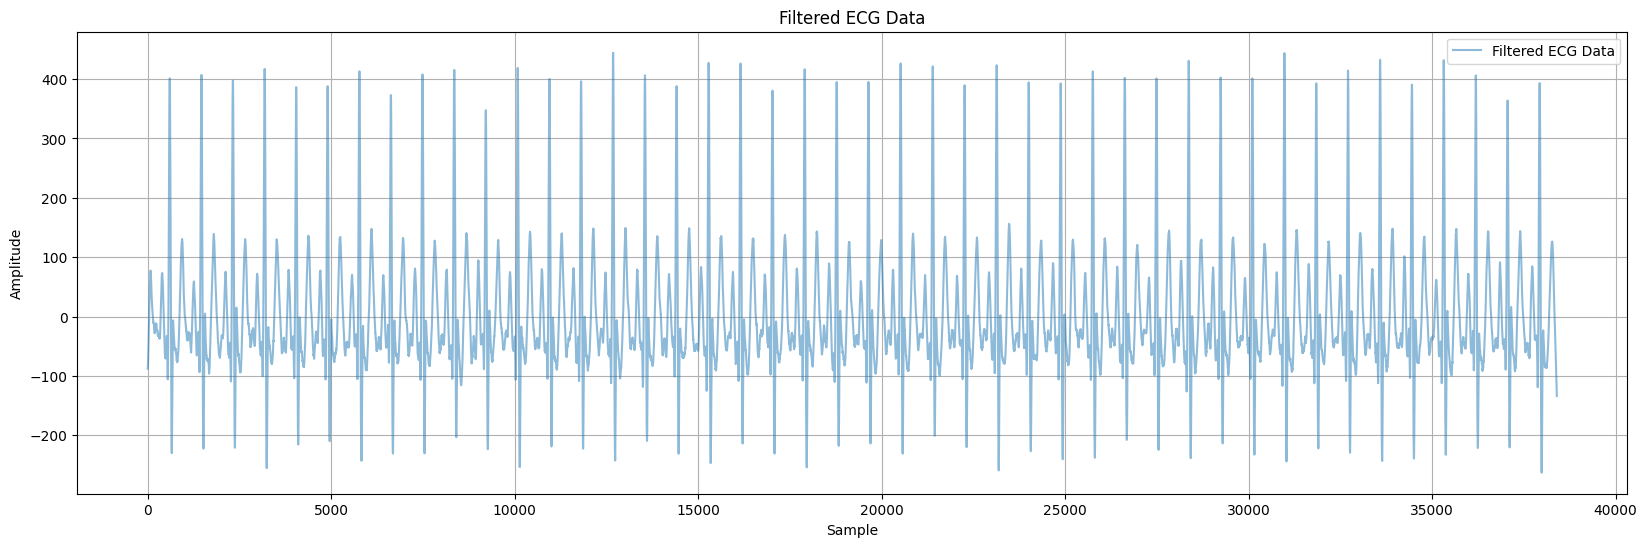

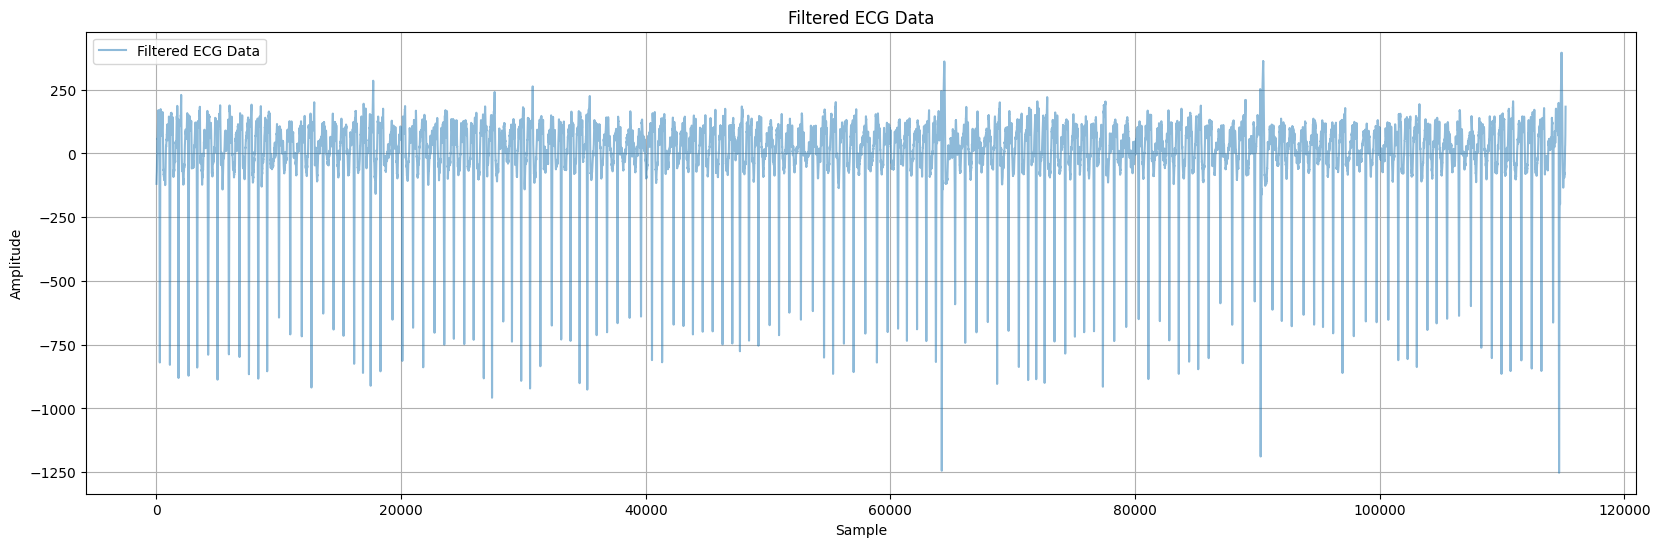

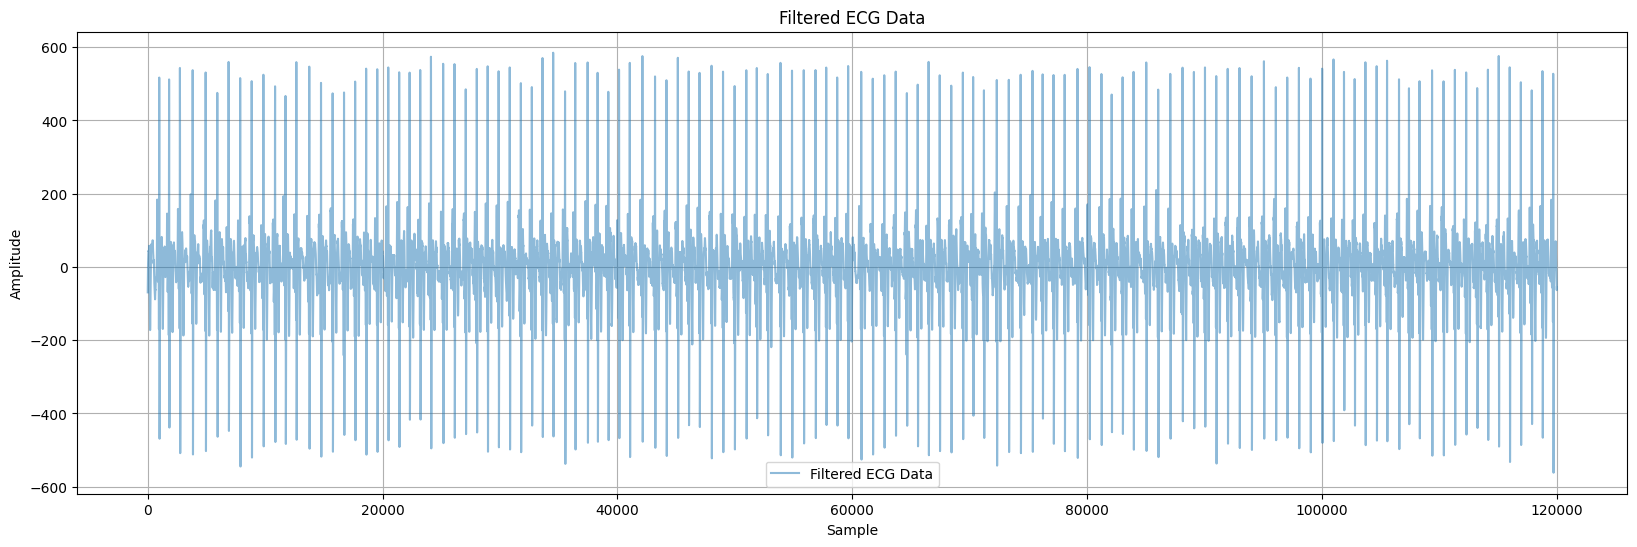

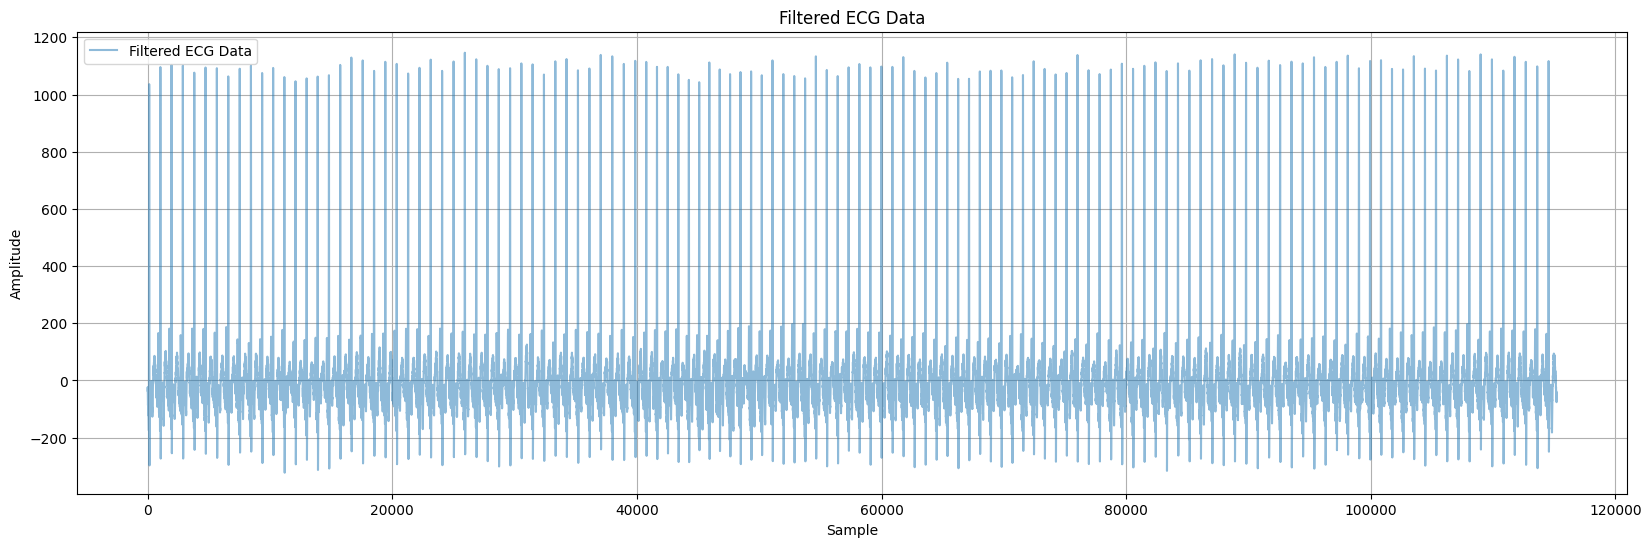

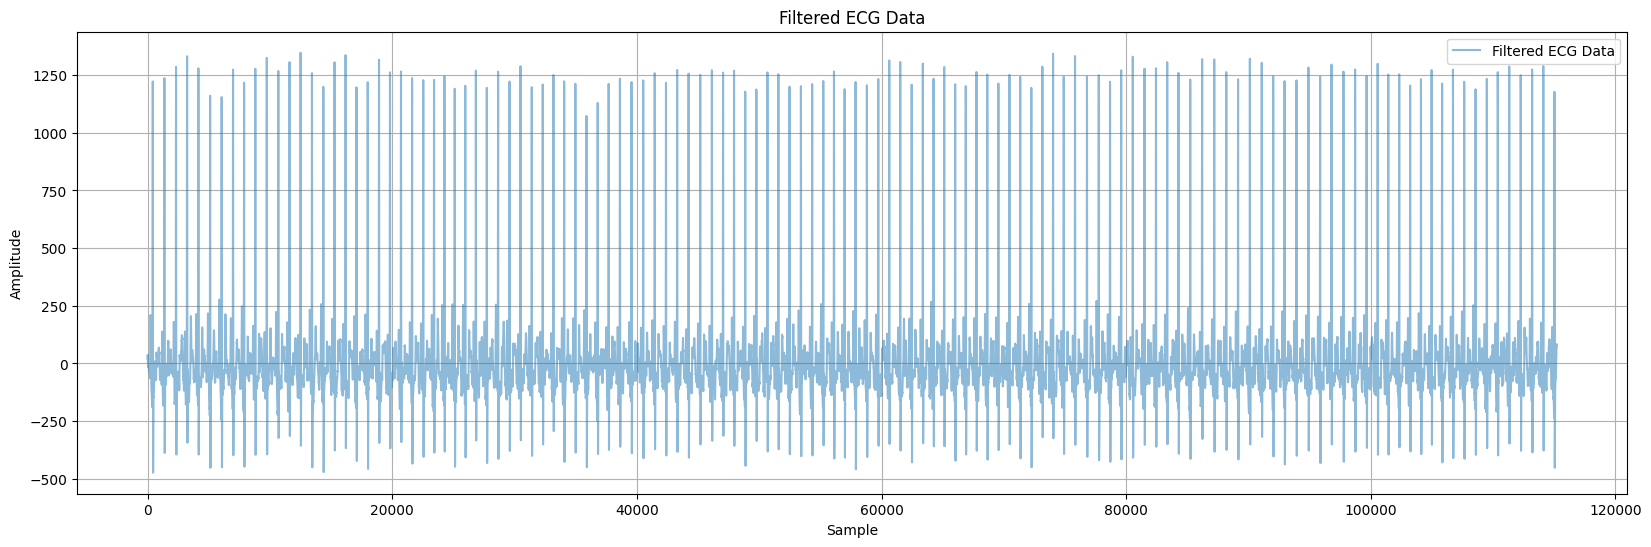

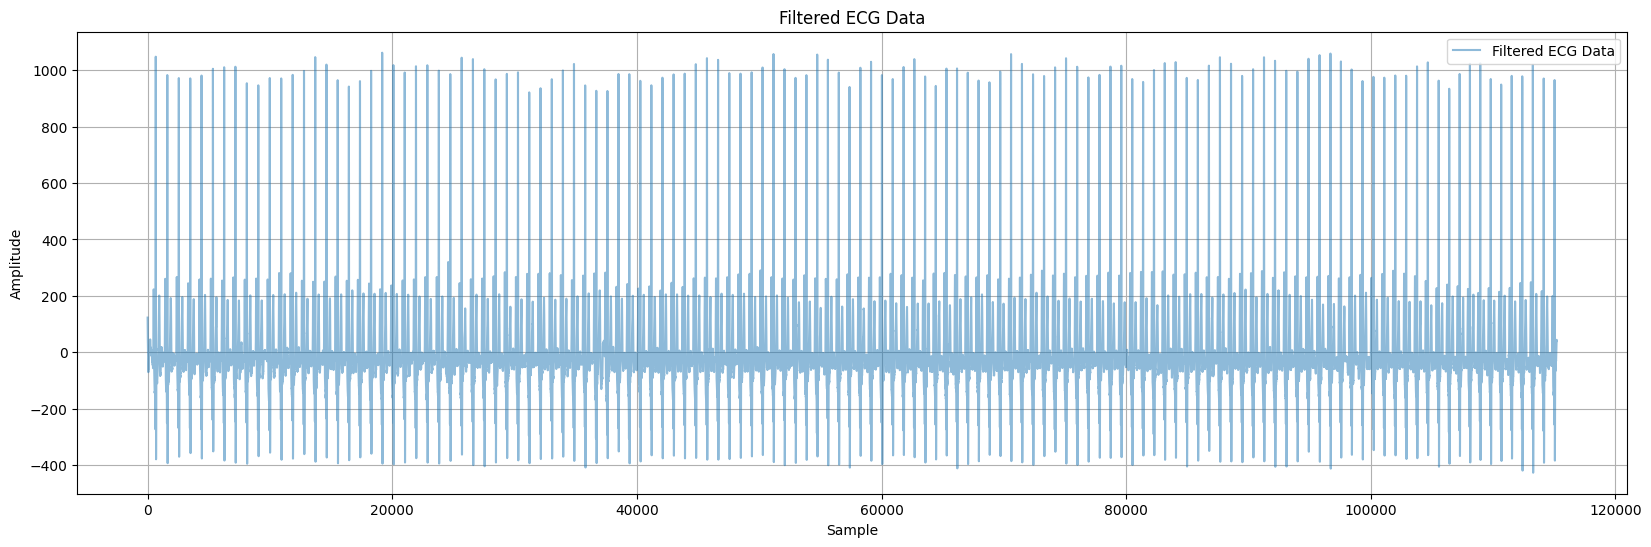

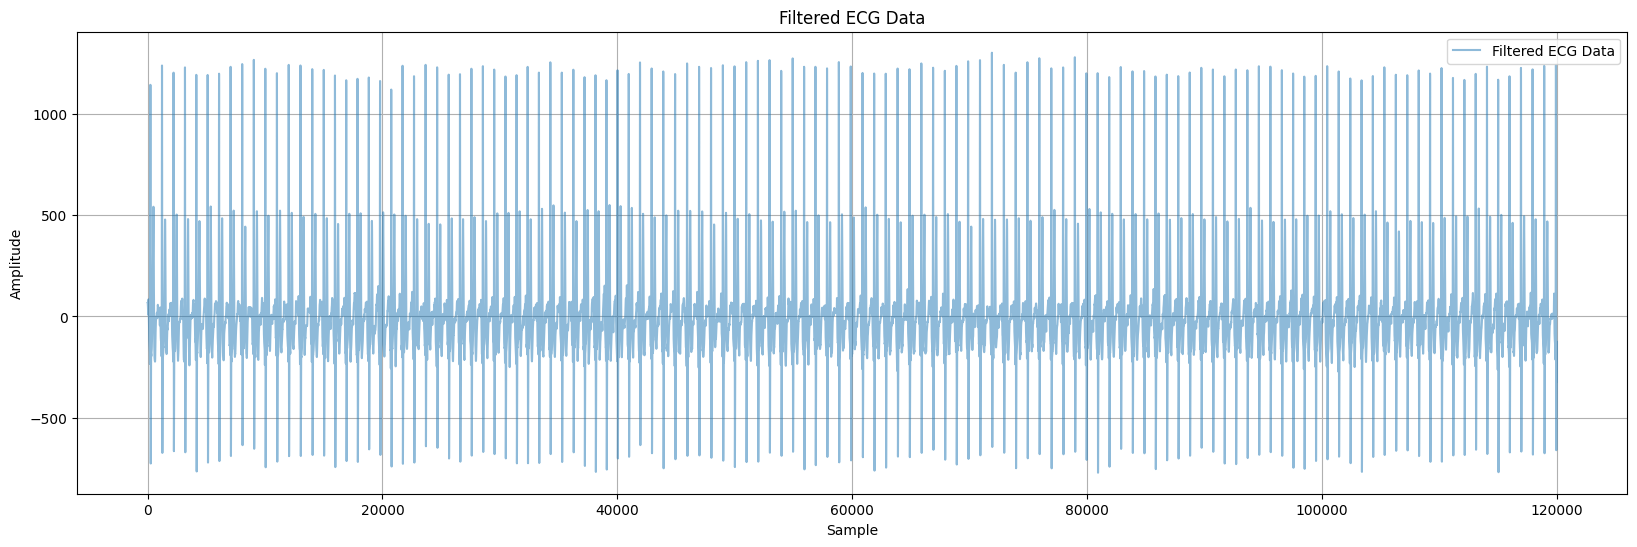

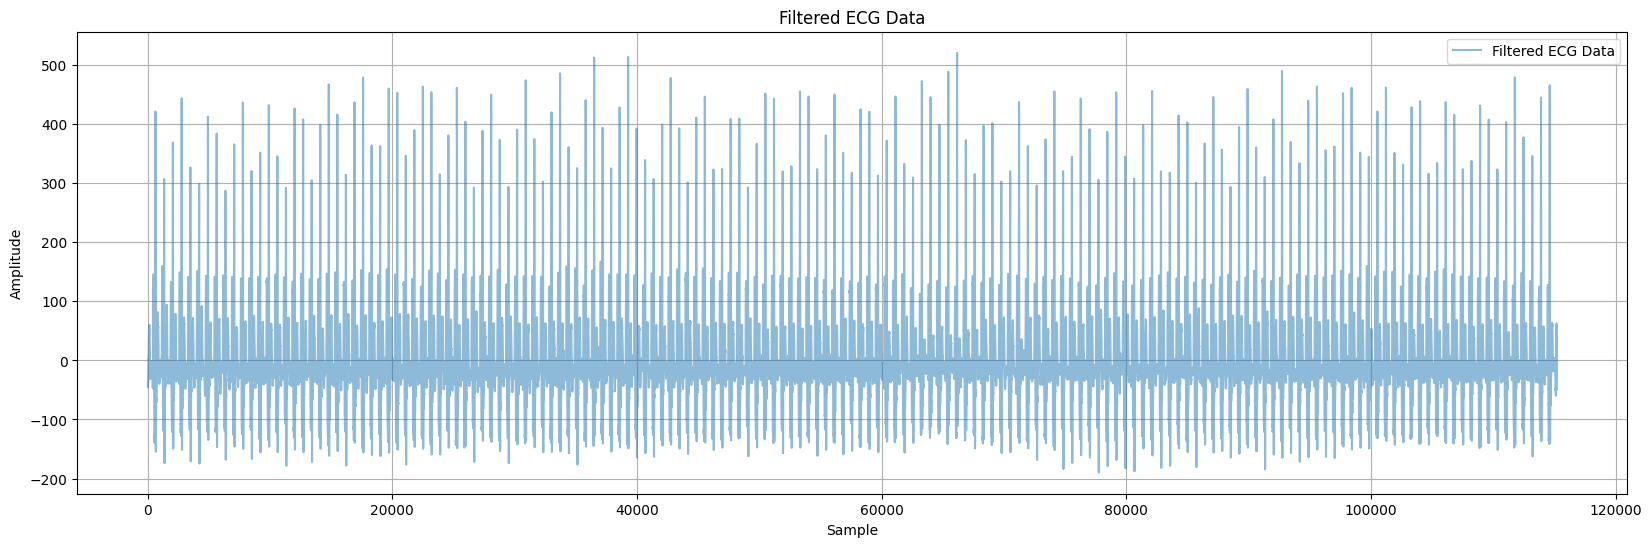

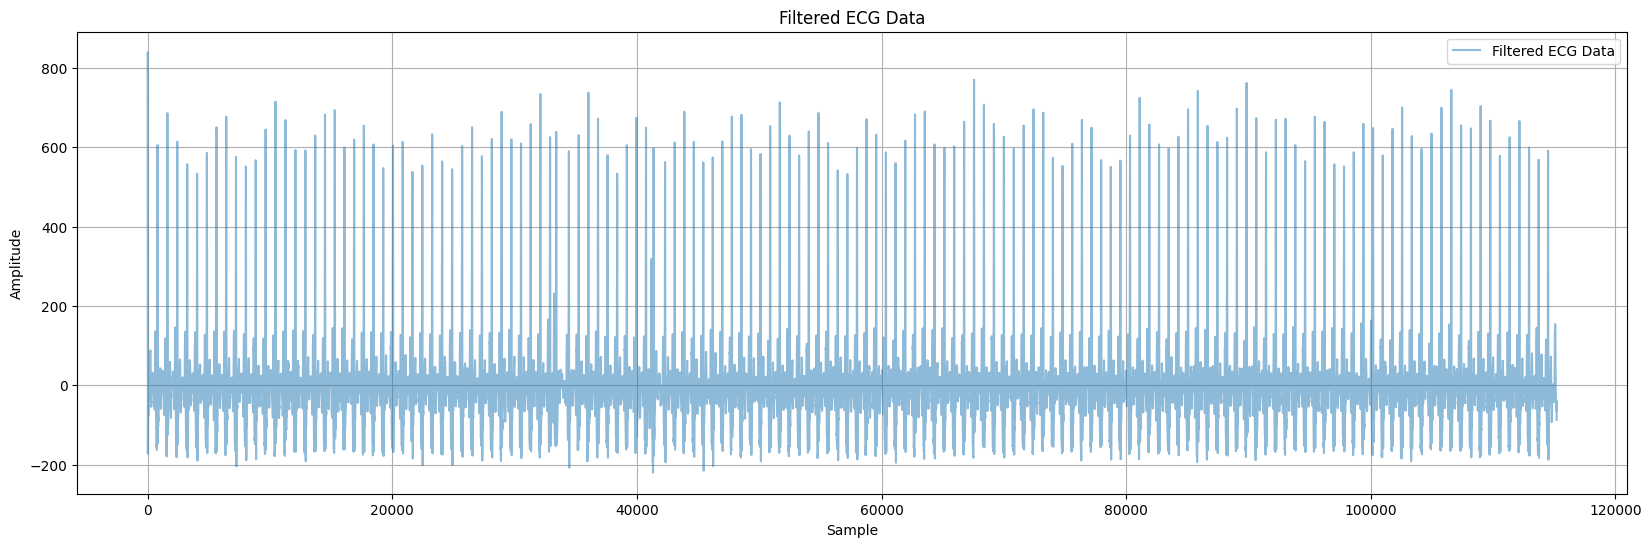

In [ ]:
if split == 'Intra':
  for i in range(3):
    plt.figure(figsize=(20, 6))
    plt.plot(X_train_record[i], label='Original ECG Data', alpha=0.5)
    #plt.plot(denoise, label='Denoised ECG Data', alpha=0.5)
    #plt.plot(baseline,label="Baseline")
    plt.plot(filtered_train[i], label='Baseline Wandering Removed', alpha=1)

    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title('Original vs SG Smoothed ECG Data')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
  for fold in fold_data:

    # Get trainset, valset, and testset from each fold
    X_train_record = fold['train']['X']
    X_val_record = fold['val']['X']
    X_test_record = fold['test']['X']

    for i in range(3):
      plt.figure(figsize=(20, 6))
      plt.plot(X_train_record[i], label='Filtered ECG Data', alpha=0.5)
      #plt.plot(denoise, label='Denoised ECG Data', alpha=0.5)
      #plt.plot(baseline,label="Baseline")
      #plt.plot(filtered_train[i], label='Baseline Wandering Removed', alpha=1)

      plt.xlabel('Sample')
      plt.ylabel('Amplitude')
      plt.title('Filtered ECG Data')
      plt.legend()
      plt.grid(True)
      plt.show()

    for i in range(3):
      plt.figure(figsize=(20, 6))
      plt.plot(X_val_record[i], label='Filtered ECG Data', alpha=0.5)
      #plt.plot(denoise, label='Denoised ECG Data', alpha=0.5)
      #plt.plot(baseline,label="Baseline")
      #plt.plot(filtered_train[i], label='Baseline Wandering Removed', alpha=1)

      plt.xlabel('Sample')
      plt.ylabel('Amplitude')
      plt.title('Filtered ECG Data')
      plt.legend()
      plt.grid(True)
      plt.show()

    for i in range(3):
      plt.figure(figsize=(20, 6))
      plt.plot(X_test_record[i], label='Filtered ECG Data', alpha=0.5)
      #plt.plot(denoise, label='Denoised ECG Data', alpha=0.5)
      #plt.plot(baseline,label="Baseline")
      #plt.plot(filtered_train[i], label='Baseline Wandering Removed', alpha=1)

      plt.xlabel('Sample')
      plt.ylabel('Amplitude')
      plt.title('Filtered ECG Data')
      plt.legend()
      plt.grid(True)
      plt.show()
    break

### 5.3 Save / Read filtered signal

In [ ]:
# if split == 'Intra':

#   mode='intra'
#   with open(f'{mode}_filtered_train.pkl', 'wb') as f:
#       pickle.dump(filtered_train, f)

#   with open(f'{mode}_filtered_test.pkl', 'wb') as f:
#       pickle.dump(filtered_test, f)

# else:

#   with open(f'{skf.n_splits}fold_data.pkl', 'wb') as f:
#     pickle.dump(fold_data, f)

In [ ]:
# if split == 'Intra':

#   mode='intra'
#   with open(f'{mode}_filtered_train.pkl', 'rb') as f:
#     filtered_train = pickle.load(f)

#   with open(f'{mode}_filtered_test.pkl', 'rb') as f:
#     filtered_test = pickle.load(f)

# else:

#   with open(f'{skf.n_splits}fold_data.pkl', 'rb') as f:
#     fold_data = pickle.load(f)

### 5.4 R-peak algorithm

In [ ]:
# Pan-Tompkins Algorithm
class Pan_Tompkins_QRS():

  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds.

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()

    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12]

    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal):
    '''
    Derivative Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*1000)/8

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * 1000)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum

    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned.
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    global der
    der = self.derivative(bpass.copy())

    # Squaring Function
    global sqr
    sqr = self.squaring(der.copy())

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqr.copy())

    return mwin


In [ ]:
# Importing Libraries
from scipy import signal as sg

class heart_rate():

  def __init__(self,signal,samp_freq):
    '''
    Initialize Variables
    :param signal: input signal
    :param samp_freq: sample frequency of input signal
    '''

    # Initialize variables
    self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
    self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

    self.T_wave = False
    self.m_win = mwin
    self.b_pass = bpass
    self.samp_freq = samp_freq
    self.signal = signal
    self.win_150ms = round(0.15*self.samp_freq)

    self.RR_Low_Limit = 0
    self.RR_High_Limit = 0
    self.RR_Missed_Limit = 0
    self.RR_Average1 = 0


  def approx_peak(self):
    '''
    Approximate peak locations
    '''

    # FFT convolution
    slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

    # Finding approximate peak locations
    for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            self.peaks.append(i)


  def adjust_rr_interval(self,ind):
    '''
    Adjust RR Interval and Limits
    :param ind: current index in peaks array
    '''

    # Finding the eight most recent RR intervals
    self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.samp_freq

    # Calculating RR Averages
    self.RR_Average1 = np.mean(self.RR1)
    RR_Average2 = self.RR_Average1

    # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit
    if (ind >= 8):
        for i in range(0, 8):
            if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit):
                self.RR2.append(self.RR1[i])

                if (len(self.RR2) > 8):
                    self.RR2.remove(self.RR2[0])
                    RR_Average2 = np.mean(self.RR2)

    # Adjusting the RR Low Limit and RR High Limit
    if (len(self.RR2) > 7 or ind < 8):
        self.RR_Low_Limit = 0.92 * RR_Average2
        self.RR_High_Limit = 1.16 * RR_Average2
        self.RR_Missed_Limit = 1.66 * RR_Average2


  def searchback(self,peak_val,RRn,sb_win):
      '''
      Searchback
      :param peak_val: peak location in consideration
      :param RRn: the most recent RR interval
      :param sb_win: searchback window
      '''

      # Check if the most recent RR interval is greater than the RR Missed Limit
      if (RRn > self.RR_Missed_Limit):
          # Initialize a window to searchback
          win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1]

          # Find the x locations inside the window having y values greater than Threshold I1
          coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

          # Find the x location of the max peak value in the search window
          if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      x_max = pos
                      break
          else:
            x_max = None

          # If the max peak value is found
          if (x_max is not None):
            # Update the thresholds corresponding to moving window integration
            self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI
            self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
            self.Threshold_I2 = 0.5 * self.Threshold_I1

            # Initialize a window to searchback
            win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]

            # Find the x locations inside the window having y values greater than Threshold F1
            coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      r_max = pos
                      break
            else:
              r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:
                  self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF
                  self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                  self.Threshold_F2 = 0.5 * self.Threshold_F1

                  # Append the probable R peak location
                  self.r_locs.append(r_max)


  def find_t_wave(self,peak_val,RRn,ind,prev_ind):
    '''
    T Wave Identification
    :param peak_val: peak location in consideration
    :param RRn: the most recent RR interval
    :param ind: current index in peaks array
    :param prev_ind: previous index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1):
        if (ind > 0 and 0.20 < RRn < 0.36):
          # Find the slope of current and last waveform detected
          curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
          last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))

          # If current waveform slope is less than half of last waveform slope
          if (curr_slope < 0.5*last_slope):
              # T Wave is found and update noise threshold
              self.T_wave = True
              self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI

        if (not self.T_wave):
            # T Wave is not found and update signal thresholds
            if (self.probable_peaks[ind] > self.Threshold_F1):
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])

            else:
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF

    # Update noise thresholds
    elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def adjust_thresholds(self,peak_val,ind):
    '''
    Adjust Noise and Signal Thresholds During Learning Phase
    :param peak_val: peak location in consideration
    :param ind: current index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1):
        # Update signal threshold
        self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

        if (self.probable_peaks[ind] > self.Threshold_F1):
            self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF

            # Append the probable R peak location
            self.r_locs.append(self.probable_peaks[ind])

        else:
            # Update noise threshold
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF

    # Update noise thresholds
    elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def update_thresholds(self):
    '''
    Update Noise and Signal Thresholds for next iteration
    '''

    self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
    self.Threshold_I2 = 0.5 * self.Threshold_I1
    self.Threshold_F2 = 0.5 * self.Threshold_F1
    self.T_wave = False


  def ecg_searchback(self):
    '''
    Searchback in ECG signal to increase efficiency
    '''

    # Filter the unique R peak locations
    self.r_locs = np.unique(np.array(self.r_locs).astype(int))

    # Initialize a window to searchback
    win_200ms = round(0.2*self.samp_freq)

    for r_val in self.r_locs:
        coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

        # Find the x location of the max peak value
        if (len(coord) > 0):
          for pos in coord:
              if (self.signal[pos] == max(self.signal[coord])):
                  x_max = pos
                  break
        else:
          x_max = None

        # Append the peak location
        if (x_max is not None):
          self.result.append(x_max)


  def find_r_peaks(self):
    '''
    R Peak Detection
    '''

    # Find approximate peak locations
    self.approx_peak()

    # Iterate over possible peak locations
    for ind in range(len(self.peaks)):

        # Initialize the search window for peak detection
        peak_val = self.peaks[ind]
        win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
        max_val = max(self.b_pass[win_300ms], default = 0)

        # Find the x location of the max peak value
        if (max_val != 0):
          x_coord = np.asarray(self.b_pass == max_val).nonzero()
          self.probable_peaks.append(x_coord[0][0])

        if (ind < len(self.probable_peaks) and ind != 0):
            # Adjust RR interval and limits
            self.adjust_rr_interval(ind)

            # Adjust thresholds in case of irregular beats
            if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit):
                self.Threshold_I1 /= 2
                self.Threshold_F1 /= 2

            RRn = self.RR1[-1]

            # Searchback
            self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

            # T Wave Identification
            self.find_t_wave(peak_val,RRn,ind,ind-1)

        else:
          # Adjust threholds
          self.adjust_thresholds(peak_val,ind)

        # Update threholds for next iteration
        self.update_thresholds()

    # Searchback in ECG signal
    self.ecg_searchback()

    return self.result


### 5.5 Segmentation

In [ ]:
def segmentation(filtered_signal, y_true):
    QRS_detector = Pan_Tompkins_QRS()

    heartbeats = []
    labels = []

    for i in range(len(filtered_signal)):
      ecg = pd.DataFrame(np.array([list(range(len(filtered_signal[i]))),filtered_signal[i]]).T,columns=['TimeStamp','ecg'])
      output_signal = QRS_detector.solve(ecg)

      signal = ecg.iloc[:,1].to_numpy()
      hr = heart_rate(signal,1000)
      result = hr.find_r_peaks()
      result = np.array(result)
      result = result[result > 0]

      # For demo purpose
      plt.figure(figsize = (20,4), dpi = 100)
      plt.xticks(np.arange(0, len(signal)+1, 150))
      plt.plot(signal, color = 'blue')
      plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
      plt.xlabel('Samples')
      plt.ylabel('MLIImV')
      plt.title("R Peak Locations")

      num_heartbeat = 0
      for j in range(len(result)):
        if ((result[j]-300>=0) and (result[j]+500<=len(signal))):

            if((j == len(result)-1) and (result[j]!=result[j-1])):
              heartbeats.append(signal[result[j]-300:result[j]+500])
              num_heartbeat +=1

            if((j != len(result)-1) and (result[j]!=result[j+1])):
              heartbeats.append(signal[result[j]-300:result[j]+500])
              num_heartbeat +=1

      if (y_true[i]==1):
        for i in range(num_heartbeat):
          labels.append(1)
      else:
        for i in range(num_heartbeat):
          labels.append(0)



    return heartbeats, labels

In [ ]:
if split == 'Intra':

  heartbeats_train, labels_train = segmentation(filtered_train, y_train_record)
  heartbeats_test, labels_test = segmentation(filtered_test, y_test_record)

  fold_data = []
  n=0
  for fold, (train_idx, val_idx) in enumerate(skf.split(heartbeats_train, labels_train)):
      print(f"Fold {n+1}/{skf.n_splits}")

      # Split the data again into trainset and valset from original trainset
      X_train = [heartbeats_train[i] for i in train_idx]
      X_val = [heartbeats_train[i] for i in val_idx]
      y_train = [labels_train[i] for i in train_idx]
      y_val = [labels_train[i] for i in val_idx]

      fold_data.append({'fold': fold+1,'train': {'X': X_train, 'y': y_train},'val': {'X': X_val, 'y': y_val},'test': {'X': heartbeats_test, 'y': labels_test}})
      n+=1

else:
  n=1
  for fold in fold_data:
    print(n)
    # Get trainset, valset, and testset from each fold
    X_train_record = fold['train']['X']
    X_val_record = fold['val']['X']
    X_test_record = fold['test']['X']
    y_train_record = fold['train']['y']
    y_val_record = fold['val']['y']
    y_test_record = fold['test']['y']

    # Segmentation Start
    heartbeats_train,labels_train = segmentation(X_train_record,y_train_record)
    heartbeats_val,labels_val = segmentation(X_val_record,y_val_record)
    heartbeats_test, labels_test = segmentation(X_test_record,y_test_record)

    # Replace the filtered signal with the filtered heartbeats
    fold['train']['X'] = heartbeats_train
    fold['train']['y'] = labels_train
    fold['val']['X'] = heartbeats_val
    fold['val']['y'] = labels_val
    fold['test']['X'] = heartbeats_test
    fold['test']['y'] = labels_test
    n+=1
    # Segmentation end

1
2
3
4
5
6
7
8
9
10


In [ ]:
n=1
for fold in fold_data:
  print(n)
  n+=1
  # Get trainset, valset, and testset from each fold
  heartbeats_train = fold['train']['X']
  heartbeats_val = fold['val']['X']
  heartbeats_test = fold['test']['X']
  labels_train = fold['train']['y']
  labels_val = fold['val']['y']
  labels_test = fold['test']['y']

  print("Total number of  MI ECGs in trainset:",len([x for x in labels_train if x == 1]))
  print("Total number of normal ECGs in trainset:",len([x for x in labels_train if x == 0]),"\n")
  print("Total number of  MI ECGs in valset:",len([x for x in labels_val if x == 1]))
  print("Total number of normal ECGs in valset:",len([x for x in labels_val if x == 0]),"\n")
  print("Total number of  MI ECGs in testset:",len([x for x in labels_test if x == 1]))
  print("Total number of normal ECGs in testset:",len([x for x in labels_test if x == 0]),"\n")

  print('(Trainset) Number of heartbeats produced:', len(heartbeats_train))
  print('(Testset) Number of heartbeats:', len(heartbeats_test))
  print('(Valset) Number of heartbeats:', len(heartbeats_val))

  print('Number of labels (should be same to number of heartbeats)', len(labels_train))
  print('Number of labels (should be same to number of heartbeats)', len(labels_test))
  print('Number of labels (should be same to number of heartbeats)', len(labels_val))

  print('(Trainset) Data type of object storing heartbeats:',type(heartbeats_train))
  print('(Trainset) Data type of object storing labels', type(labels_train))
  print('(Testset) Data type of object storing heartbeats:',type(heartbeats_test))
  print('(Testset) Data type of object storing labels', type(labels_test))
  print('(Valset) Data type of object storing heartbeats:',type(heartbeats_val))
  print('(Valset) Data type of object storing labels', type(labels_val))

  print('(Trainset) Sequence length of heartbeat:',len(heartbeats_train[0]))
  print('(Testset) Sequence length of heartbeat:', len(heartbeats_test[0]))
  print('(Valset) Sequence length of heartbeat:', len(heartbeats_val[0]))

  print('(Trainset) Shape of one heartbeat:',heartbeats_train[0].shape)
  print('(Testset) Shape of one heartbeat:',heartbeats_test[0].shape)
  print('(Valset) Shape of one heartbeat:',heartbeats_val[0].shape)

  print('(Trainset) Data type of heartbeat array:', type(heartbeats_train[0]))
  print('(Trainset) Data type of label array:', type(labels_train[0]))
  print('(Testset) Data type of heartbeat array', type(heartbeats_test[0]))
  print('(Testset) Data type of label array', type(labels_test[0]))
  print('(Valset) Data type of heartbeat array', type(heartbeats_val[0]))
  print('(Valset) Data type of label array', type(labels_val[0]))

1
Total number of  MI ECGs in trainset: 39459
Total number of normal ECGs in trainset: 41208 

Total number of  MI ECGs in valset: 3684
Total number of normal ECGs in valset: 710 

Total number of  MI ECGs in testset: 11341
Total number of normal ECGs in testset: 1910 

(Trainset) Number of heartbeats produced: 80667
(Testset) Number of heartbeats: 13251
(Valset) Number of heartbeats: 4394
Number of labels (should be same to number of heartbeats) 80667
Number of labels (should be same to number of heartbeats) 13251
Number of labels (should be same to number of heartbeats) 4394
(Trainset) Data type of object storing heartbeats: <class 'list'>
(Trainset) Data type of object storing labels <class 'list'>
(Testset) Data type of object storing heartbeats: <class 'list'>
(Testset) Data type of object storing labels <class 'list'>
(Valset) Data type of object storing heartbeats: <class 'list'>
(Valset) Data type of object storing labels <class 'list'>
(Trainset) Sequence length of heartbeat: 

### 5.6 Save / Read the fold data

In [ ]:
print(split)

Inter


In [ ]:
# #Save the heartbeats and labels with pickle
# if split == 'Intra':
#   mode = 'intra'
#   with open(f'{skf.n_splits}fold_{mode}_heartbeats.pkl', 'wb') as f:
#     pickle.dump(fold_data, f)

# else:
#   mode = 'inter'
#   with open(f'{skf.n_splits}fold_{mode}_heartbeats.pkl', 'wb') as f:
#     pickle.dump(fold_data, f)

In [ ]:
#Read the heartbeats and labels with pickle
if split == 'Intra':
  mode='intra'
  with open(f'{skf.n_splits}fold_{mode}_heartbeats.pkl', 'rb') as f:
    fold_data1 = pickle.load(f)

else:
  mode='inter'
  with open(f'{skf.n_splits}fold_{mode}_heartbeats.pkl', 'rb') as f:
    fold_data = pickle.load(f)

In [ ]:
n=1
for fold in fold_data:
  print(n)
  n+=1
  # Get trainset, valset, and testset from each fold
  heartbeats_train = fold['train']['X']
  heartbeats_val = fold['val']['X']
  heartbeats_test = fold['test']['X']
  labels_train = fold['train']['y']
  labels_val = fold['val']['y']
  labels_test = fold['test']['y']

  print("Total number of  MI ECGs in trainset:",len([x for x in labels_train if x == 1]))
  print("Total number of normal ECGs in trainset:",len([x for x in labels_train if x == 0]),"\n")
  print("Total number of  MI ECGs in valset:",len([x for x in labels_val if x == 1]))
  print("Total number of normal ECGs in valset:",len([x for x in labels_val if x == 0]),"\n")
  print("Total number of  MI ECGs in testset:",len([x for x in labels_test if x == 1]))
  print("Total number of normal ECGs in testset:",len([x for x in labels_test if x == 0]),"\n")

  print('(Trainset) Number of heartbeats produced:', len(heartbeats_train))
  print('(Testset) Number of heartbeats:', len(heartbeats_test))
  print('(Valset) Number of heartbeats:', len(heartbeats_val))

  print('Number of labels (should be same to number of heartbeats)', len(labels_train))
  print('Number of labels (should be same to number of heartbeats)', len(labels_test))
  print('Number of labels (should be same to number of heartbeats)', len(labels_val))

  print('(Trainset) Data type of object storing heartbeats:',type(heartbeats_train))
  print('(Trainset) Data type of object storing labels', type(labels_train))
  print('(Testset) Data type of object storing heartbeats:',type(heartbeats_test))
  print('(Testset) Data type of object storing labels', type(labels_test))
  print('(Valset) Data type of object storing heartbeats:',type(heartbeats_val))
  print('(Valset) Data type of object storing labels', type(labels_val))

  print('(Trainset) Sequence length of heartbeat:',len(heartbeats_train[0]))
  print('(Testset) Sequence length of heartbeat:', len(heartbeats_test[0]))
  print('(Valset) Sequence length of heartbeat:', len(heartbeats_val[0]))

  print('(Trainset) Shape of one heartbeat:',heartbeats_train[0].shape)
  print('(Testset) Shape of one heartbeat:',heartbeats_test[0].shape)
  print('(Valset) Shape of one heartbeat:',heartbeats_val[0].shape)

  print('(Trainset) Data type of heartbeat array:', type(heartbeats_train[0]))
  print('(Trainset) Data type of label array:', type(labels_train[0]))
  print('(Testset) Data type of heartbeat array', type(heartbeats_test[0]))
  print('(Testset) Data type of label array', type(labels_test[0]))
  print('(Valset) Data type of heartbeat array', type(heartbeats_val[0]))
  print('(Valset) Data type of label array', type(labels_val[0]))

1
Total number of  MI ECGs in trainset: 39459
Total number of normal ECGs in trainset: 41208 

Total number of  MI ECGs in valset: 3684
Total number of normal ECGs in valset: 710 

Total number of  MI ECGs in testset: 11341
Total number of normal ECGs in testset: 1910 

(Trainset) Number of heartbeats produced: 80667
(Testset) Number of heartbeats: 13251
(Valset) Number of heartbeats: 4394
Number of labels (should be same to number of heartbeats) 80667
Number of labels (should be same to number of heartbeats) 13251
Number of labels (should be same to number of heartbeats) 4394
(Trainset) Data type of object storing heartbeats: <class 'list'>
(Trainset) Data type of object storing labels <class 'list'>
(Testset) Data type of object storing heartbeats: <class 'list'>
(Testset) Data type of object storing labels <class 'list'>
(Valset) Data type of object storing heartbeats: <class 'list'>
(Valset) Data type of object storing labels <class 'list'>
(Trainset) Sequence length of heartbeat: 